In [1]:
library('sva')
library('gPCA')
library('Biobase')
library("ggfortify")
library('DESeq2')
library(VennDiagram)
library(pheatmap)
library(EnhancedVolcano)
library("ggpubr")
library(pheatmap)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind

In [2]:
sessionInfo(package = NULL)

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/gaw006/anaconda3/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ggpubr_0.2.5                magrittr_1.5               
 [3] EnhancedVolcano_1.2.0       ggrepel_0.8.2              
 [5] pheatmap_1.0.12             VennDiagram_1.6.20         
 [7] futile.logger_1.4.3         DESeq2_1.22.1              
 [9] SummarizedExperiment_1.12.0 De

# Data

### Download raw and intermediate data from GSE169453

# cell compostion analysis

In [3]:
####
M=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/barcode_info.csv')
donor_ID1=as.character(M$index)
test=strsplit(donor_ID1, "_")
donor_IDa=donor_ID1
for (i in 1:length(test)){
   donor_IDa[i]=test[i][[1]][1]
}
M$donor=donor_IDa
leiden_ID=sort(unique(M$leiden))
donor_ID=sort(unique(M$donor))
leiden_all=M$leiden
donor_all=M$donor

S_ID=matrix(0,length(leiden_ID),length(donor_ID))
rownames(S_ID)=leiden_ID
colnames(S_ID)=donor_ID
for (i in 1:length(leiden_ID)){
    for (j in 1:length(donor_ID)){
       keep=(leiden_all==leiden_ID[i] & donor_all==donor_ID[j])
       if (dim(M[keep,])[1]>0){
           S_ID[i,j]=dim(M[keep,])[1]
       }
    }
}

### normalization
sample_totnum=colSums(S_ID)  
S_ID_norm=(S_ID - S_ID)
for (i in 1:dim(S_ID)[2]){
  S_ID_norm[,i]=S_ID[,i]*(10000/sample_totnum[i])
}

In [4]:
## cell types
alpha_ID=c(0,4,8)+1
beta_ID=c(1,2,3,5)+1
delta_ID=c(6)+1
gamma_ID=c(10)+1
acinar_ID=c(7)+1
ductal_ID=c(9)+1
stellate_ID=c(11)+1
endothelial_ID=c(13)+1
immune_ID=c(12)+1

CS=matrix(0,9,dim(S_ID_norm)[2])
rownames(CS)=c('alpha','beta','delta','gamma','acinar','ductal','stellate','endothelial','immune')
colnames(CS)=colnames(S_ID_norm)

CS[1,]=colSums(S_ID_norm[alpha_ID,])
CS[2,]=colSums(S_ID_norm[beta_ID,])
CS[3,]=S_ID_norm[delta_ID,]
CS[4,]=S_ID_norm[gamma_ID,]
CS[5,]=S_ID_norm[acinar_ID,]
CS[6,]=S_ID_norm[ductal_ID,]
CS[7,]=S_ID_norm[stellate_ID,]
CS[8,]=S_ID_norm[endothelial_ID,]
CS[9,]=S_ID_norm[immune_ID,]

totnum=colSums(CS)
S_ID_norm1=(CS - CS)
for (i in 1:dim(CS)[2]){
  S_ID_norm1[,i]=CS[,i]*(100/totnum[i])
}

A2=t(CS)
A2_colsum=colSums(A2)
A2_rowsum=rowSums(A2)
A_row=(A2-A2)
for (i in 1:dim(A2)[1]){
    A_row[i,]=100*(A2[i,]/A2_rowsum[i])
}
A=as.data.frame(A_row)

In [5]:
A

,alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune
JYH792,31.37255,53.47943,3.921569,0.8650519,4.440600,3.9792388,0.5574779,0.5382545,0.8458285
JYH809,57.37171,19.09887,2.828536,1.2015019,9.637046,5.3066333,2.8285357,0.8760951,0.8510638
MM108,30.19834,29.68650,5.310301,0.9170399,24.418853,7.1230540,1.0023459,0.6824483,0.6611218
MM109,38.14163,44.39865,8.786062,2.8287748,2.847508,1.1052829,0.8242788,0.6182091,0.4496066
MM110,36.25629,49.48776,8.942525,0.9550269,1.354402,1.7885049,0.4341031,0.2778260,0.5035596
MM12,60.50990,19.11225,4.438738,3.0997799,8.308877,2.3110785,0.5869406,0.5869406,1.0454879
MM120,47.76881,35.39046,7.263233,1.8751484,3.999525,1.6377878,1.1274626,0.4984572,0.4391170
MM121,40.22782,45.88329,8.073541,0.9392486,2.098321,1.1191047,0.7394085,0.4396483,0.4796163
MM122,36.46363,44.51296,9.999167,2.8664278,2.949754,1.0749104,0.8915924,0.8249313,0.4166319
MM123,35.20997,51.41732,7.230971,1.0367454,3.175853,0.9055118,0.4461942,0.1181102,0.4593176


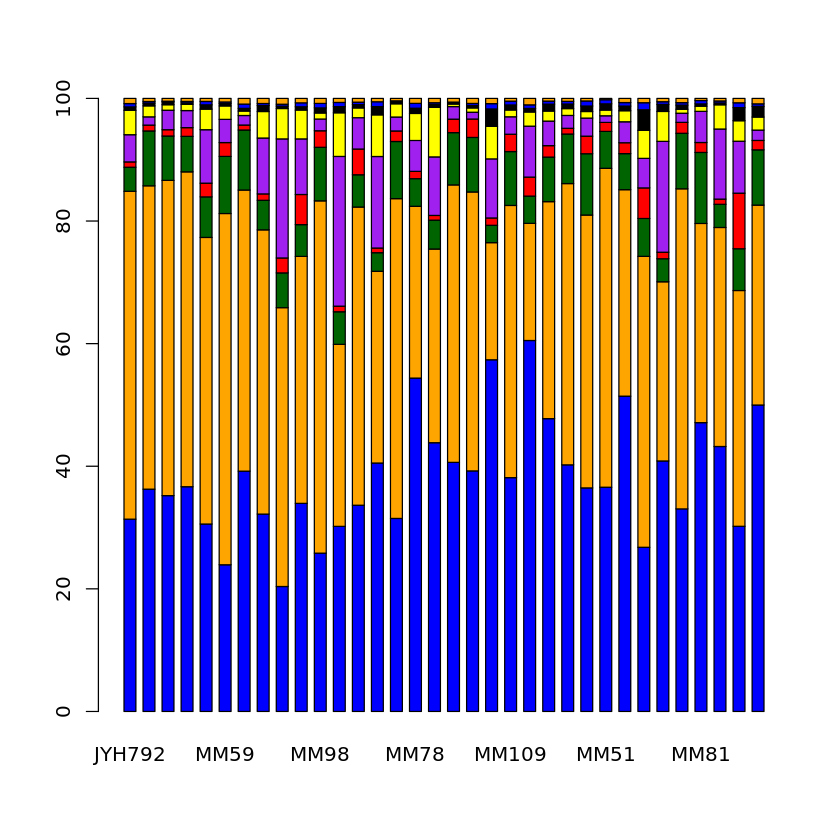

In [6]:
###clinical information of donors (orderred)
C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
keep=(C$donor %in% rownames(A))
C=C[keep,]
C=C[order(C$donor),]

C1=C[order(C$Sample.Description.Name),]
A1=A[order(C$Sample.Description.Name),]
A2=t(as.matrix(A1))
barplot(A2, space=0.6,col=c("blue","orange","darkgreen","red","purple","yellow","black"),legend.text=FALSE,args.legend=list(
      x=65,
      y=1,
      bty = "n"
    ))


In [7]:
### add clinical infromation to each donor
A$Disease=C$Sample.Description.Name
A$method=C$Freezing.storage.method
A$center=C$Center
A$islet.index=C$islet.index
A$age=C$Age
A$gender=C$Gender
A$BMI=C$BMI
A$HbA1c=C$HbA1c
A$Purity=C$Purity

## cell composition analysis

In [8]:
alpha_cell <- aov(alpha ~ Disease + age + islet.index + gender + BMI, data = A)

summary(alpha_cell)

            Df Sum Sq Mean Sq F value Pr(>F)   
Disease      2  811.6   405.8   5.860 0.0077 **
age          1    2.7     2.7   0.039 0.8445   
islet.index  1  117.6   117.6   1.698 0.2035   
gender       1   68.9    68.9   0.995 0.3273   
BMI          1   27.5    27.5   0.398 0.5336   
Residuals   27 1869.6    69.2                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [9]:
beta_cell <- aov(beta ~ Disease + age + islet.index + gender + BMI, data = A)

summary(beta_cell)

            Df Sum Sq Mean Sq F value  Pr(>F)   
Disease      2 1004.4   502.2   6.169 0.00622 **
age          1   11.4    11.4   0.140 0.71130   
islet.index  1  212.2   212.2   2.606 0.11807   
gender       1   12.0    12.0   0.147 0.70434   
BMI          1   25.1    25.1   0.308 0.58362   
Residuals   27 2198.1    81.4                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [10]:
delta_cell <- aov(delta ~ Disease + age + islet.index + gender + BMI, data = A)

summary(delta_cell)

            Df Sum Sq Mean Sq F value Pr(>F)  
Disease      2   3.08   1.538   0.281 0.7575  
age          1   0.06   0.055   0.010 0.9209  
islet.index  1  21.60  21.603   3.943 0.0573 .
gender       1   0.01   0.013   0.002 0.9622  
BMI          1   0.78   0.781   0.142 0.7088  
Residuals   27 147.94   5.479                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [11]:
gamma_cell <- aov(gamma ~ Disease + age + islet.index + gender + BMI, data = A)

summary(gamma_cell)

            Df Sum Sq Mean Sq F value Pr(>F)
Disease      2   3.02   1.510   0.516  0.603
age          1   0.12   0.118   0.040  0.843
islet.index  1   6.53   6.533   2.230  0.147
gender       1   2.86   2.864   0.978  0.332
BMI          1   0.08   0.077   0.026  0.872
Residuals   27  79.09   2.929               

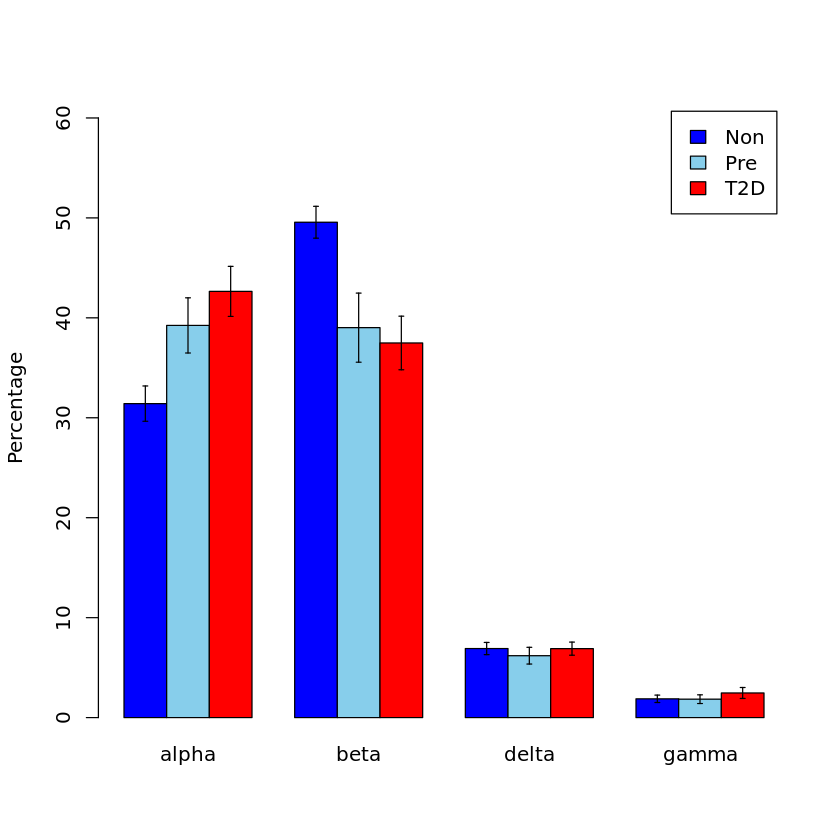

In [12]:
### disease (all cells)
A_mean=aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~Disease , data=A , mean)
rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 1.25*max(A_mean)

error.bar <- function(x, y, upper, lower=upper, length=0.02,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}
stdev <- aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~Disease, data=A , sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
name=as.character(A$Disease)
group=rownames(A_mean)
for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

ze_barplot <- barplot(A_mean[,c(1:4)], beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue","skyblue",'red'),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean[,c(1:4)], stdev[,c(1:4)])


,alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune
F,37.27343,41.05224,6.780566,1.778868,8.284489,2.988352,0.7752135,0.5236231,0.5432112
M,38.55002,42.00624,6.721289,2.254717,5.626835,2.759574,0.8993007,0.5126043,0.6694257


,alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune
F,9.369665,8.689239,2.207352,0.6776528,8.844627,2.595165,0.4058253,0.2519388,0.2105326
M,9.541143,10.903023,2.366978,1.8988082,4.139968,1.934844,0.7912220,0.2385951,0.1852398


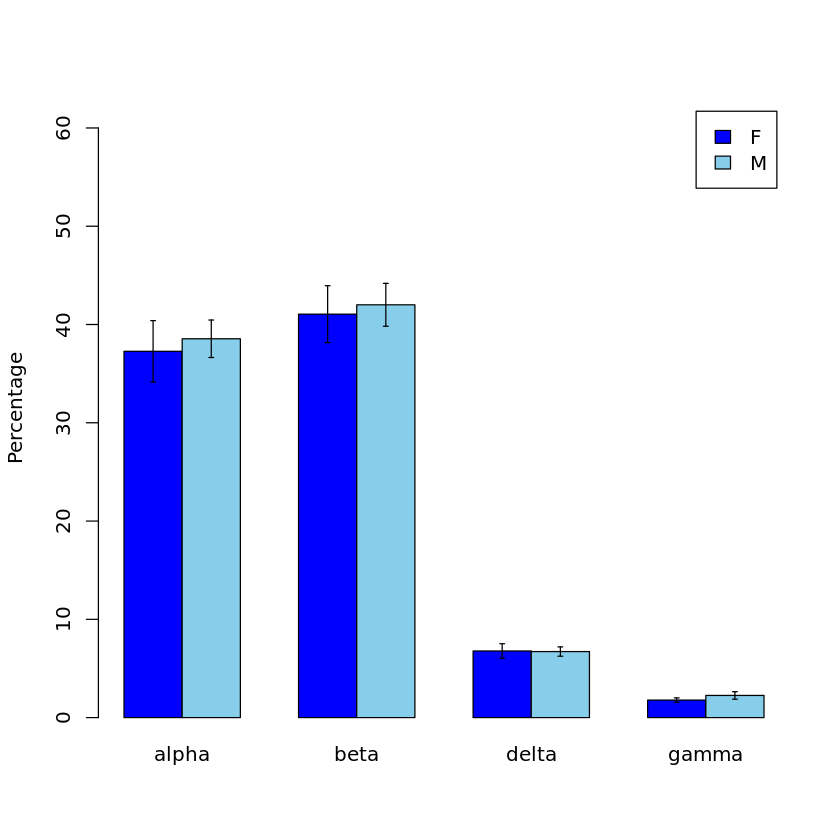

In [13]:
### gender
A_mean=aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~gender , data=A , mean)
rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 1.5*max(A_mean)
A_mean

error.bar <- function(x, y, upper, lower=upper, length=0.02,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

###
stdev <- aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~gender, data=A , sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
stdev

###
name=as.character(A$gender)
group=rownames(A_mean)


for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

ze_barplot <- barplot(A_mean[,c(1:4)], beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue","skyblue"),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean[,c(1:4)], stdev[,c(1:4)])



In [14]:
### P-value (alpha)
alpha_per=as.numeric(A$alpha)
alpha_F=alpha_per[name=='F']
alpha_M=alpha_per[name=='M']
temp=t.test(alpha_F,alpha_M)
print('alpha F_M:')
print(temp)

### P-value (beta)
beta_per=as.numeric(A$beta)
beta_F=beta_per[name=='F']
beta_M=beta_per[name=='M']
temp=t.test(beta_F,beta_M)
print('beta F_M:')
print(temp)

### P-value (delta)
delta_per=as.numeric(A$delta)
delta_F=delta_per[name=='F']
delta_M=delta_per[name=='M']
temp=t.test(delta_F,delta_M)
print('delta F_M:')
print(temp)

### P-value (gamma)
gamma_per=as.numeric(A$gamma)
gamma_F=gamma_per[name=='F']
gamma_M=gamma_per[name=='M']
temp=t.test(gamma_F,gamma_M)
print('gamma F_M:')
print(temp)


[1] "alpha F_M:"

	Welch Two Sample t-test

data:  alpha_F and alpha_M
t = -0.34879, df = 14.418, p-value = 0.7323
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -9.105284  6.552120
sample estimates:
mean of x mean of y 
 37.27343  38.55002 

[1] "beta F_M:"

	Welch Two Sample t-test

data:  beta_F and beta_M
t = -0.26313, df = 17.739, p-value = 0.7955
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -8.578917  6.670928
sample estimates:
mean of x mean of y 
 41.05224  42.00624 

[1] "delta F_M:"

	Welch Two Sample t-test

data:  delta_F and delta_M
t = 0.067752, df = 15.13, p-value = 0.9469
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.804173  1.922728
sample estimates:
mean of x mean of y 
 6.780566  6.721289 

[1] "gamma F_M:"

	Welch Two Sample t-test

data:  gamma_F and gamma_M
t = -1.0769, df = 31.978, p-value = 0.2896
al

,alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune
old,40.51012,40.31801,7.045185,2.184072,5.549572,2.373024,0.8823232,0.5390430,0.5986476
young,35.91407,43.18941,6.428774,2.073443,7.111091,3.267241,0.8505849,0.4919991,0.6733844


,alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune
old,10.113542,11.956243,2.661642,1.143318,4.916758,1.870634,0.6399584,0.2156912,0.2162940
young,8.222761,8.313235,1.885562,2.101854,6.501859,2.253984,0.7859275,0.2635902,0.1745593


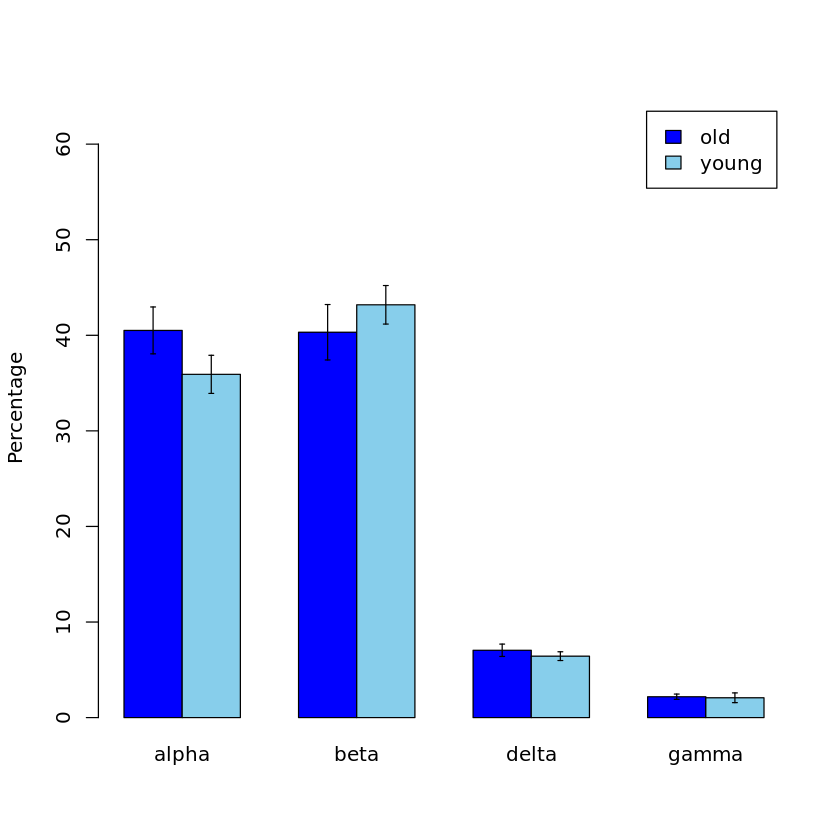

In [15]:
### age
age_num=A$age
age=age_num
age[age_num>=median(age_num)]='old'
age[age_num<median(age_num)]='young'
A$age=age

A_mean=aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~age , data=A , mean)
rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 1.5*max(A_mean)
A_mean

error.bar <- function(x, y, upper, lower=upper, length=0.02,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

###
stdev <- aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~age, data=A , sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
stdev

###
name=as.character(A$age)
group=rownames(A_mean)


for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

ze_barplot <- barplot(A_mean[,c(1:4)], beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue","skyblue"),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean[,c(1:4)], stdev[,c(1:4)])



In [16]:
### P-value (alpha)
alpha_per=as.numeric(A$alpha)
alpha_o=alpha_per[name=='old']
alpha_y=alpha_per[name=='young']
temp=t.test(alpha_o,alpha_y)
print('alpha:')
print(temp)

### P-value (beta)
beta_per=as.numeric(A$beta)
beta_o=beta_per[name=='old']
beta_y=beta_per[name=='young']
temp=t.test(beta_o,beta_y)
print('beta:')
print(temp)

### P-value (delta)
delta_per=as.numeric(A$delta)
delta_o=delta_per[name=='old']
delta_y=delta_per[name=='young']
temp=t.test(delta_o,delta_y)
print('delta:')
print(temp)


### P-value (gamma)
gamma_per=as.numeric(A$gamma)
gamma_o=gamma_per[name=='old']
gamma_y=gamma_per[name=='young']
temp=t.test(gamma_o,gamma_y)
print('gamma:')
print(temp)

[1] "alpha:"

	Welch Two Sample t-test

data:  alpha_o and alpha_y
t = 1.4538, df = 30.721, p-value = 0.1561
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.853895 11.045986
sample estimates:
mean of x mean of y 
 40.51012  35.91407 

[1] "beta:"

	Welch Two Sample t-test

data:  beta_o and beta_y
t = -0.81299, df = 28.54, p-value = 0.423
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -10.099976   4.357187
sample estimates:
mean of x mean of y 
 40.31801  43.18941 

[1] "delta:"

	Welch Two Sample t-test

data:  delta_o and delta_y
t = 0.77917, df = 28.828, p-value = 0.4422
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.002020  2.234842
sample estimates:
mean of x mean of y 
 7.045185  6.428774 

[1] "gamma:"

	Welch Two Sample t-test

data:  gamma_o and gamma_y
t = 0.19064, df = 24.706, p-value = 0.8504
alternative hypothes

,alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune
high,8.415574,8.545347,1.972050,2.036378,7.194277,2.268349,0.5200974,0.1766487,0.1744110
low,10.477280,11.958850,2.631031,1.256755,3.691393,1.955212,0.8651495,0.2813043,0.2160555


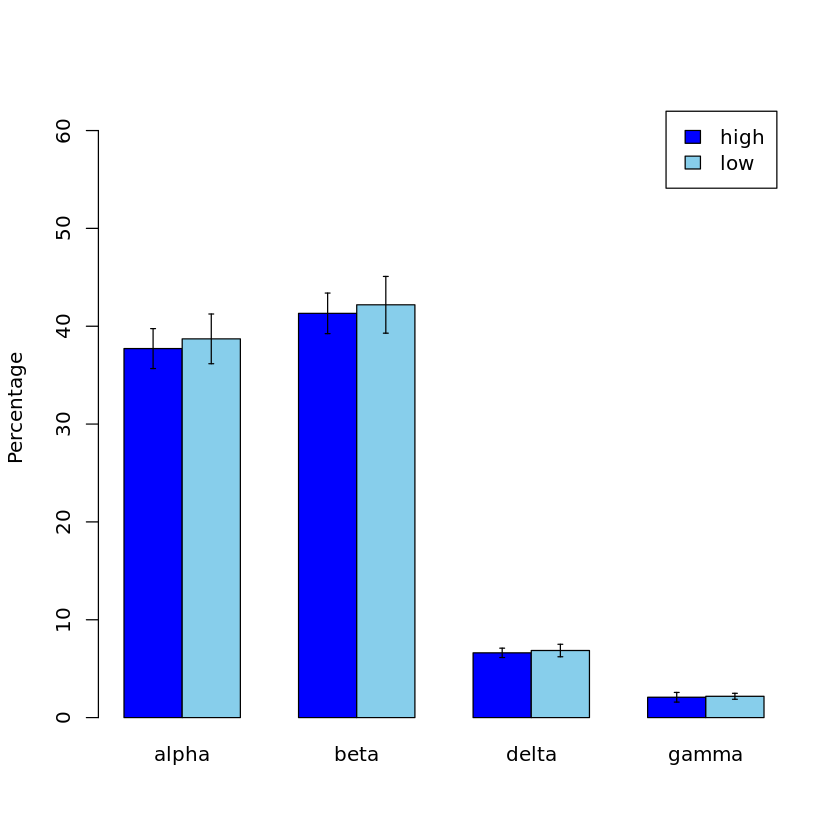

In [17]:
### BMI
BMI_num=A$BMI
BMI=BMI_num
BMI[BMI_num>=median(BMI_num)]='high'
BMI[BMI_num<median(BMI_num)]='low'
A$BMI=BMI

A_mean=aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~BMI , data=A , mean)
rownames(A_mean) <- A_mean[,1]
A_mean <- as.matrix(A_mean[,-1])
lim <- 1.5*max(A_mean)

error.bar <- function(x, y, upper, lower=upper, length=0.02,...){
  arrows(x,y+upper, x, y-lower, angle=90, code=3, length=length, ...)
}

###
stdev <- aggregate(cbind(alpha,beta,delta,gamma,acinar,ductal,stellate,endothelial,immune)~BMI, data=A , sd)
rownames(stdev) <- stdev[,1]
stdev <- as.matrix(stdev[,-1])
stdev

###
name=as.character(A$BMI)
group=rownames(A_mean)


for (i in 1:length(group)){
    temp_num=length(name[name==group[i]])
    stdev[i,]=(stdev[i,]/sqrt(temp_num))
}

ze_barplot <- barplot(A_mean[,c(1:4)], beside=TRUE ,space=c(0,1),legend.text=TRUE,col=c("blue","skyblue"),ylim=c(0,lim), ylab="Percentage")
error.bar(ze_barplot,A_mean[,c(1:4)], stdev[,c(1:4)])


In [18]:
### P-value (alpha)
alpha_per=as.numeric(A$alpha)
alpha_h=alpha_per[name=='high']
alpha_l=alpha_per[name=='low']
temp=t.test(alpha_h,alpha_l)
print('alpha:')
print(temp)

### P-value (beta)
beta_per=as.numeric(A$beta)
beta_h=beta_per[name=='high']
beta_l=beta_per[name=='low']
temp=t.test(beta_h,beta_l)
print('beta:')
print(temp)

### P-value (delta)
delta_per=as.numeric(A$delta)
delta_h=delta_per[name=='high']
delta_l=delta_per[name=='low']
temp=t.test(delta_h,delta_l)
print('delta:')
print(temp)


### P-value (gamma)
gamma_per=as.numeric(A$gamma)
gamma_h=gamma_per[name=='high']
gamma_l=gamma_per[name=='low']
temp=t.test(gamma_h,gamma_l)
print('gamma:')
print(temp)

[1] "alpha:"

	Welch Two Sample t-test

data:  alpha_h and alpha_l
t = -0.30476, df = 30.578, p-value = 0.7626
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -7.644495  5.657861
sample estimates:
mean of x mean of y 
 37.71544  38.70875 

[1] "beta:"

	Welch Two Sample t-test

data:  beta_h and beta_l
t = -0.24483, df = 28.96, p-value = 0.8083
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -8.164122  6.418567
sample estimates:
mean of x mean of y 
 41.31732  42.19010 

[1] "delta:"

	Welch Two Sample t-test

data:  delta_h and delta_l
t = -0.29911, df = 29.665, p-value = 0.7669
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.867959  1.390890
sample estimates:
mean of x mean of y 
 6.617713  6.856247 

[1] "gamma:"

	Welch Two Sample t-test

data:  gamma_h and gamma_l
t = -0.1705, df = 26.644, p-value = 0.8659
alternative hypoth

# PCA

In [19]:
## PCA plots for beta cell
rm(list = ls())
c_type='beta'

# beta cell open cCREs
name_1=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_peak_macs2_q0.05.bed')
C1=read.table(name_1,sep='\t')
peak_c1=unique(as.character(C1$V4))

## beta cell bulk count matrix
name_c3=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_500_all_b.csv')
C3=read.csv(name_c3)
peak_all_c3=as.character(C3$index)
C3_matrix=as.matrix(C3[,-1])
rownames(C3_matrix)=peak_all_c3
keep=(peak_all_c3 %in% peak_c1)
C3_final=C3_matrix[keep,]

## count normalization (CPM)
A_norm = C3_final - C3_final
r_sum=colSums(C3_final)
for (i in 1:dim(A_norm)[2]){
  A_norm[,i]=((1000000/r_sum[i])*C3_final[,i])
}
A_raw=C3_final

## metadata of donors
C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
C=C[order(C$donor),]
all(C$donor==colnames(A_norm))


pca <- prcomp(t(A_norm), scale. = TRUE)
pc_pos=pca$x


[1] TRUE

## PC1 and PC2

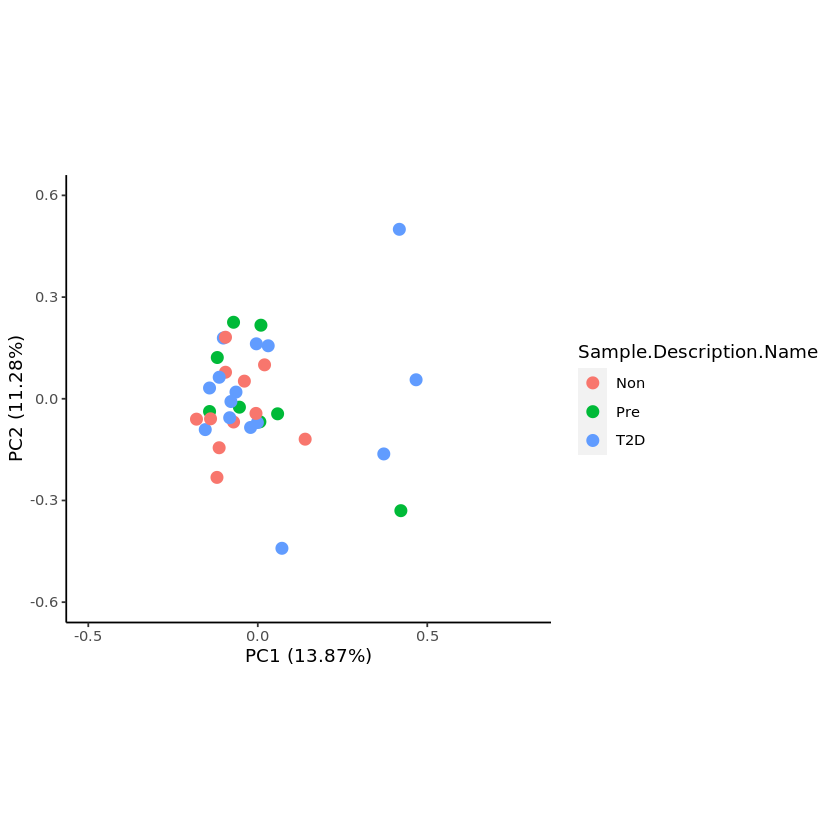

In [20]:
p1 <- autoplot(pca,    
         data=C,
         colour = 'Sample.Description.Name',size=3,
         x = 1,    # PC2
         y = 2) + scale_size_continuous(range = c(1,3))+ xlim(c(-0.5,0.8)) + ylim(-0.6, 0.6) + coord_fixed()

p1 + ggplot2::theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))



## PC3 and PC4

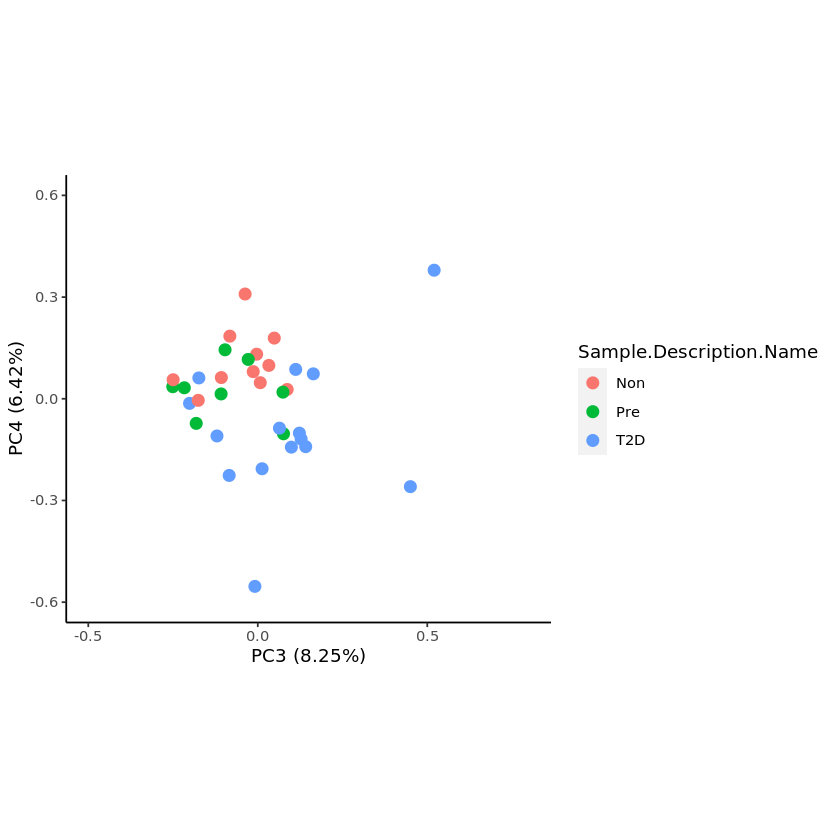

In [21]:
p1 <- autoplot(pca, 
         data=C,
         colour = 'Sample.Description.Name',size=3,
         x = 3,
         y = 4) + scale_size_continuous(range = c(1,3))+ xlim(c(-0.5,0.8)) + ylim(-0.6, 0.6) + coord_fixed()

p1 + ggplot2::theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))


## Spearman correlations between PCs and variables

In [22]:
pos=pca$x
C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
C=C[order(C$donor),]
all(rownames(pos)==as.character(C$donor))

C1=C[,c(1,3,5,7:13,15,17:20,23:29)]
temp=C1$Sample.Description.Name
temp1=rep(0,length(temp))
temp1[temp=='Non']=0
temp1[temp=='Pre']=1
temp1[temp=='T2D']=2
C1$disease1=temp1

temp1=rep(0,length(temp))
temp1[temp=='Non']=0
temp1[temp=='Pre']=2
temp1[temp=='T2D']=1
C1$disease2=temp1

temp1=rep(0,length(temp))
temp1[temp=='Non']=1
temp1[temp=='Pre']=0
temp1[temp=='T2D']=2
C1$disease3=temp1

temp=C1$Freezing.storage.method
temp1=rep(0,length(temp))
temp1[temp=='snap frozen']=1
temp1[temp=='Dry ice frozen']=0
C1$method1=temp1

temp=C1$Gender
temp1=rep(0,length(temp))
temp1[temp=='M']=1
temp1[temp=='F']=0
C1$Gender1=temp1

temp=C1$Center
temp1=rep(0,length(temp))
temp1[temp=='CH']=1
temp1[temp!='CH']=0
C1$Center1=temp1

C2=C1[,c(1,5,6,9,10,12:28)]
C_matrix=as.matrix(C2[,-1])
rownames(C_matrix)=as.character(C2$donor)


all(rownames(C_matrix)==colnames(A_norm))
total_count1=colSums(C3_matrix)
C_matrix=cbind(C_matrix,total_count1)

R=matrix(0,10,dim(C_matrix)[2])
colnames(R)=colnames(C_matrix)
rownames(R)=c(1:10)
for (i in 1:dim(R)[1]){
    for (j in 1:dim(R)[2]){
        temp_i=pos[,i]
        temp_j=C_matrix[,j]
        R[i,j]=cor(temp_i,temp_j,method="spearman")
    }
}


[1] TRUE

[1] TRUE

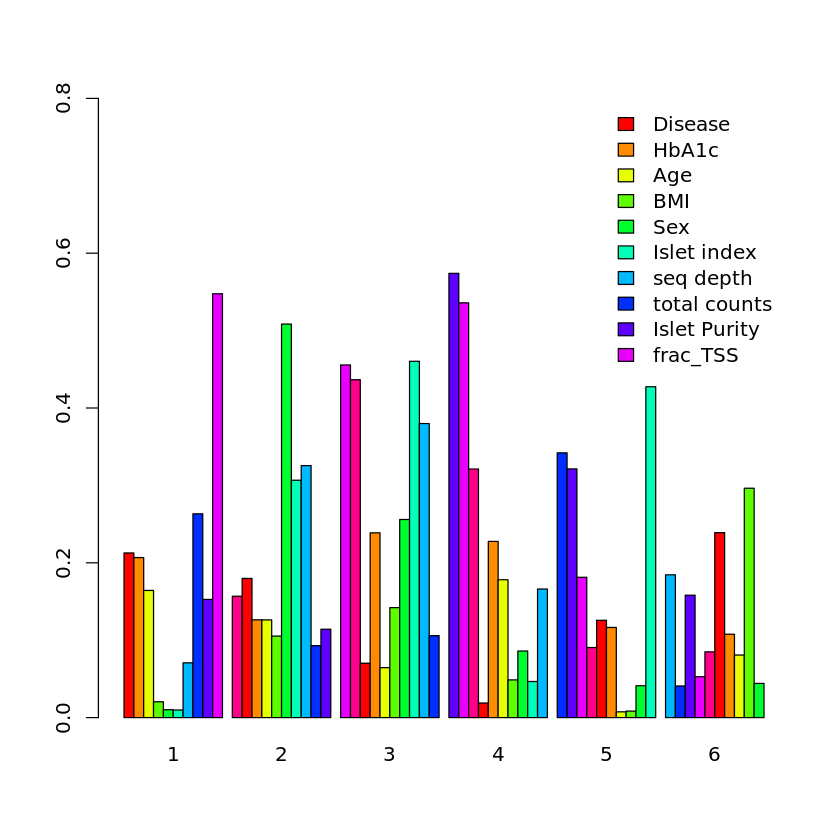

In [23]:
R1=R[1:6,c(1:5,9:10,19:20,22)]
R_temp=abs(R[1:6,16:18])
disease=apply(R_temp,1,max)
R2=cbind(R1,disease)

colnames(R2)=c('Islet index','Age', 'BMI','HbA1c','seq depth','Islet Purity','frac_TSS','Method','Sex','total counts','Disease')
R3=R2[,c(11,4,2,3,9,1,5,10,6,7)]

name_var <- colnames(R3)
barplot(abs(t(R3)), beside = T, legend.text=TRUE,col=rainbow(dim(R2)[2]),ylim=c(0,0.8),args.legend = list(x = "topright", bty = "n"))



## Spearman correlations between variables

[1] "islet.index"  "Age"          "BMI"          "HbA1c"        "seq_deep"    
 [6] "cell_num_1"   "cell_num_2"   "TSS_enrich"   "Purity"       "TSS_frac"    
[11] "map_frac"     "beta_cell"    "alpha_cell"   "delta_cell"   "gamma_cell"  
[16] "disease1"     "disease2"     "disease3"     "method1"      "Gender1"     
[21] "Center1"      "total_count1"

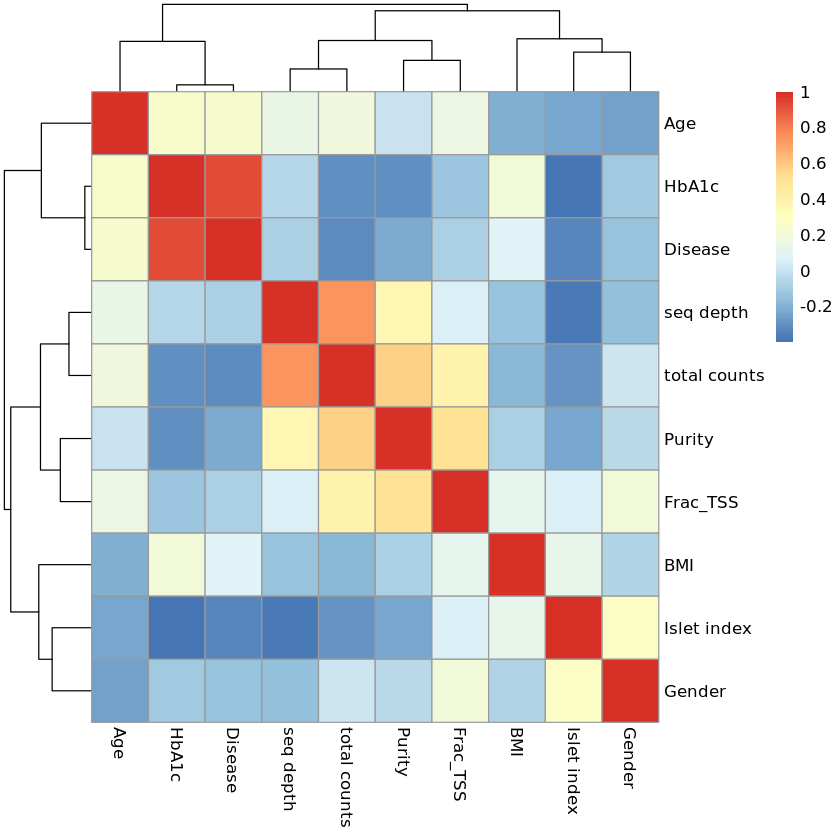

In [24]:
V=matrix(0,dim(C_matrix)[2],dim(C_matrix)[2])
colnames(V)=colnames(C_matrix)
rownames(V)=colnames(C_matrix)
for (i in 1:dim(V)[1]){
    for (j in 1:dim(V)[2]){
        temp_i=C_matrix[,i]
        temp_j=C_matrix[,j]
        V[i,j]=cor(temp_i,temp_j,method="spearman")
    }
}

colnames(V)
colnames(V)=c('Islet index','Age', 'BMI','HbA1c','seq depth','total cell number','total cell number','TSS enrichment','Purity','Frac_TSS','Fraction_genome','beta cell number','alpha cell number','delta cell number','gamma cell number','Disease','disease2','disease3','Method','Gender','Center','total counts')
rownames(V)=colnames(V)

keep=c(1:5,9,10,20,22,16)
V1=V[keep,keep]
library(pheatmap)
pheatmap(V1)

# Call differential cCREs using Deseq2

In [9]:
## beta cell as an example
rm(list = ls())
c_type='beta'

## beta cell open cCREs
name_c1=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_peak_macs2_q0.05.bed')
C1=read.table(name_c1,sep='\t')
peak_c1=unique(as.character(C1$V4))

## beta cell bulk count matrix
name_c3=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_500_all_b.csv')
C3=read.csv(name_c3)
peak_all_c3=as.character(C3$index)
C3_matrix=as.matrix(C3[,-1])
rownames(C3_matrix)=peak_all_c3
keep=(rownames(C3_matrix) %in% peak_c1)
A_raw=C3_matrix[keep,]

## metadata of donors
C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
C=C[order(C$donor),]
C$total_count=(colSums(A_raw)/100000)
all(as.character(C$donor) == colnames(A_raw))


[1] TRUE

In [10]:
### call differential cCRES using age, BMI, gender, TSS_frac, islet index, total count as covariants
dds <- DESeqDataSetFromMatrix(countData = A_raw,
                              colData = C,
                              design= ~ Age + BMI + Gender + TSS_frac + islet.index + total_count + Sample.Description.Name)

dds$Sample.Description.Name <- relevel(dds$Sample.Description.Name, ref = "Non")

library("BiocParallel")
register(MulticoreParam(4))
dds <- DESeq(dds,parallel=TRUE)

resultsNames(dds)

converting counts to integer mode
  the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 4 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 4 workers


[1] "Intercept"                          "Age"                               
[3] "BMI"                                "Gender_M_vs_F"                     
[5] "TSS_frac"                           "islet.index"                       
[7] "total_count"                        "Sample.Description.Name_Pre_vs_Non"
[9] "Sample.Description.Name_T2D_vs_Non"

## differential cCREs (FDR<0.1) between T2D and Non

In [11]:
res <- results(dds,contrast=c("Sample.Description.Name", "T2D", "Non"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])


[1] 3097

[1] 3614

## differential cCREs (FDR<0.1) between pre-T2D and Non

In [12]:
res <- results(dds,contrast=c("Sample.Description.Name", "Pre", "Non"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])


[1] 0

[1] 0

## differential cCREs (FDR<0.1) between T2D and pre-T2D

In [13]:
res <- results(dds,contrast=c("Sample.Description.Name", "T2D", "Pre"))
resOrdered <- res[order(res$pvalue),]
temp=res$padj
stat=res$stat
temp[is.na(temp)]=1
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])


[1] 61

[1] 98

## differential cCREs (FDR<0.1) in terms of age

In [14]:
res <- results(dds,name="Age")
temp=res$padj
stat=res$stat
temp[is.na(temp)]=10
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])


[1] 154

[1] 147

## differential cCREs (FDR<0.1) in terms of BMI

In [15]:
res <- results(dds,name="BMI")
temp=res$padj
stat=res$stat
temp[is.na(temp)]=10
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])


[1] 0

[1] 0

## differential cCREs (FDR<0.1) between male and female

In [16]:
res <- results(dds,name="Gender_M_vs_F")
temp=res$padj
stat=res$stat
temp[is.na(temp)]=10
length(temp[temp<0.1 & stat>0])
length(temp[temp<0.1 & stat<0])


[1] 37

[1] 89

# barplot

In [26]:
## beta cell as an example
rm(list = ls())
c_type='beta'

## beta cell open cCREs
name_c1=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_peak_macs2_q0.05.bed')
C1=read.table(name_c1,sep='\t')
peak_c1=unique(as.character(C1$V4))

## beta cell bulk count matrix
name_c3=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_500_all_b.csv')
C3=read.csv(name_c3)
peak_all_c3=as.character(C3$index)
C3_matrix=as.matrix(C3[,-1])
rownames(C3_matrix)=peak_all_c3
keep=(peak_all_c3 %in% peak_c1)
C3_final=C3_matrix[keep,]

## count normalization (CPM)
A_norm = C3_final - C3_final
r_sum=colSums(C3_final)
for (i in 1:dim(A_norm)[2]){
  A_norm[,i]=((1000000/r_sum[i])*C3_final[,i])
}
A_raw=C3_final

C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
C=C[order(C$donor),]
all(C$donor==colnames(A_norm))


[1] TRUE

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”Coordinate system already present. Adding new coordinate system, which will replace the existing one.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


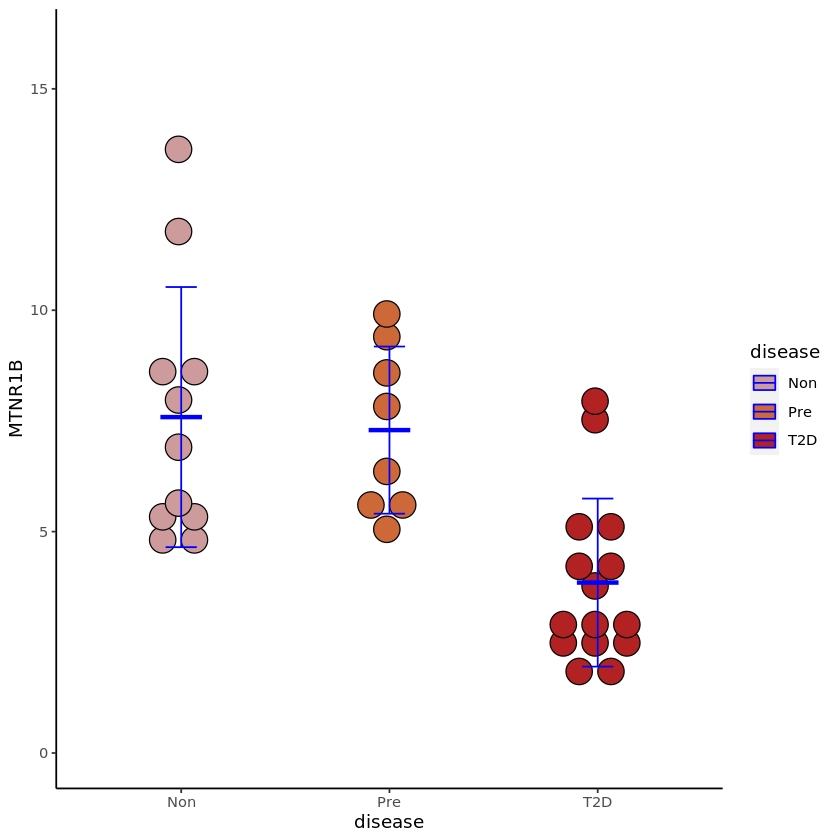

In [27]:
## promoter of MTNR1B (11:92702605-92703105)

A_temp=A_norm[rownames(A_norm) %in% ('11:92702605-92703105'),]
D=as.data.frame(t(A_norm[1:2,]))
D$disease=C$Sample.Description.Name
D$MTNR1B=A_norm[rownames(A_norm) %in% ('11:92702605-92703105'),]

library(ggplot2) 
p <- ggplot(D, aes(x=disease, y=MTNR1B,fill=disease)) + geom_dotplot(binaxis='y',stackdir='center',stackratio=1.2,dotsize=1.5)

p1 <- p + stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="blue", width=0.15) + stat_summary(fun.y=mean, geom="crossbar",size=0.5,width=0.2,color="blue") + scale_fill_manual(values=c("#CD9B9B", "#CD6839", "#B22222"))

p1 + ggplot2::coord_cartesian(xlim=c(-3,3)) + ggplot2::coord_cartesian(ylim=c(0,16)) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”Coordinate system already present. Adding new coordinate system, which will replace the existing one.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


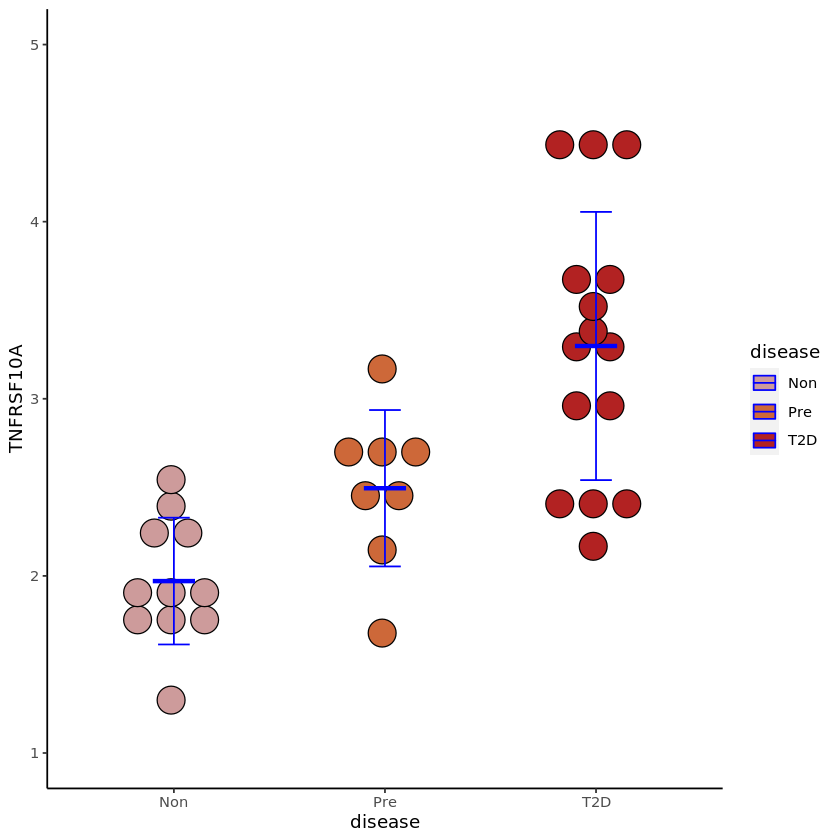

In [28]:
## promoter of TNFRSF10A (8:23082393-23082893)

A_temp=A_norm[rownames(A_norm) %in% ('8:23082393-23082893'),]
D=as.data.frame(t(A_norm[1:2,]))
D$disease=C$Sample.Description.Name
D$TNFRSF10A=A_norm[rownames(A_norm) %in% ('8:23082393-23082893'),]


library(ggplot2) 
p <- ggplot(D, aes(x=disease, y=TNFRSF10A,fill=disease)) + geom_dotplot(binaxis='y',stackdir='center',stackratio=1.2,dotsize=1.5)

p1 <- p + stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="blue", width=0.15) + stat_summary(fun.y=mean, geom="crossbar",size=0.5,width=0.2,color="blue") + scale_fill_manual(values=c("#CD9B9B", "#CD6839", "#B22222"))

p1 + ggplot2::coord_cartesian(xlim=c(-3,3)) + ggplot2::coord_cartesian(ylim=c(1,5)) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))


# correlation between chromatin accessibility and gene expression

In [5]:
####### ATAC signal (Non-T2D vs T2D): promoter region
## diff peaks and genes
A1=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/TNdown_biobank_1kb.bed_1.csv')
A2=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/TNup_biobank_1kb.bed_1.csv')
A=rbind(A1,A2)
A_u=A
A_u$X=A_u$V4

## fold changes of peaks
A_TN=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_T2D_Non_biobank.csv') ##
A_TN[is.na(A_TN)]=10

MP=merge(A_TN,A_u,by='X',all=FALSE)
MP$X=MP$V8
dim(MP)

[1] 676  15

In [6]:
####### ATAC signal (Non-T2D vs T2D): enhancer region
A1=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/TNdown_biobank.bed_unique.csv')
A2=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/TNup_biobank.bed_unique.csv')
A=rbind(A1,A2)
A=A[!duplicated(A[,c(5,10)]),]
A$X=A$V4
A=A[,c(1,10)]

## diff peaks
A_TN=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_T2D_Non_biobank.csv') ##
A_TN[is.na(A_TN)]=10

ME=merge(A_TN,A,by='X',all=FALSE)
ME$X=ME$V9
dim(ME)
ME[1:10,]

[1] 286   8

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V9
VAV3,116.628731,-0.6087304,0.1767862,-3.443314,5.746319e-04,0.0396296596,VAV3
KIAA1324,149.267052,-0.6909936,0.1997294,-3.459650,5.408782e-04,0.0383446475,KIAA1324
C2CD4D,93.237952,-1.1183759,0.2072036,-5.397475,6.758541e-08,0.0001202475,C2CD4D
PYGO2,68.906964,0.9200014,0.2858860,3.218071,1.290558e-03,0.0629249720,PYGO2
SLC50A1,68.906964,0.9200014,0.2858860,3.218071,1.290558e-03,0.0629249720,SLC50A1
PBX1,14.844213,1.1642904,0.3718169,3.131354,1.740024e-03,0.0745208063,PBX1
PLXNA2,82.054896,0.7072129,0.2205042,3.207253,1.340091e-03,0.0644259879,PLXNA2
CAMK1G,105.864853,-1.1124697,0.2804421,-3.966843,7.283098e-05,0.0117541853,CAMK1G
LAMB3,26.173523,-0.8414249,0.2591814,-3.246471,1.168454e-03,0.0595895322,LAMB3
RCOR3,7.781903,-0.9759162,0.2998526,-3.254653,1.135310e-03,0.0586311039,RCOR3


In [7]:
####### ATAC signal (Non-T2D vs T2D): enhancer nearest genes
A=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/TN_distal_10kb_gene_unique.csv')
A=A[!duplicated(A[,c(2,3)]),]
A$X=A$V7
A=A[,c(1,3)]
A[1:4,]

## diff peaks
A_TN=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_T2D_Non_biobank.csv') ##
A_TN[is.na(A_TN)]=10

MN=merge(A_TN,A,by='X',all=FALSE)
MN$X=MN$V12
dim(MN)
MN[1:10,]

X,V12
1:1322818-1323318,CCNL2
1:1373334-1373834,VWA1
1:1746189-1746689,GNB1
1:1814925-1815425,GNB1


[1] 2203    8

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V12
UBE4B,24.589936,0.9037258,0.2418484,3.736744,1.864182e-04,0.02045131,UBE4B
CASZ1,99.790501,-0.5401879,0.1579106,-3.420847,6.242650e-04,0.04172231,CASZ1
KIAA1324,58.465253,-0.4586125,0.1451973,-3.158546,1.585583e-03,0.07059763,KIAA1324
KIAA1324,149.267052,-0.6909936,0.1997294,-3.459650,5.408782e-04,0.03834465,KIAA1324
SARS,35.195836,-0.5789557,0.1651770,-3.505062,4.565015e-04,0.03484891,SARS
KIAA1324,35.195836,-0.5789557,0.1651770,-3.505062,4.565015e-04,0.03484891,KIAA1324
SORT1,8.875527,1.1221406,0.3735291,3.004159,2.663164e-03,0.09349892,SORT1
C1orf127,108.044824,0.4816776,0.1440439,3.343964,8.259037e-04,0.04908698,C1orf127
MTOR,17.031119,1.5964834,0.3808223,4.192201,2.762614e-05,0.00645644,MTOR
TRIM33,14.377691,-0.7289461,0.2375398,-3.068732,2.149692e-03,0.08342393,TRIM33


In [8]:
## merge ME and MN
colnames(MN)=colnames(ME)
MA=rbind(MN,ME)
MA[1:4,]
dim(MA)

MA=MA[!duplicated(MA[,c(1,2)]),]
dim(MA)

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,V9
UBE4B,24.58994,0.9037258,0.2418484,3.736744,0.0001864182,0.02045131,UBE4B
CASZ1,99.79050,-0.5401879,0.1579106,-3.420847,0.0006242650,0.04172231,CASZ1
KIAA1324,58.46525,-0.4586125,0.1451973,-3.158546,0.0015855827,0.07059763,KIAA1324
KIAA1324,149.26705,-0.6909936,0.1997294,-3.459650,0.0005408782,0.03834465,KIAA1324


[1] 2489    8

[1] 2431    8

In [9]:
#### public scRNAseq data
D_xin=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/Xin_DE.csv')
D_xin[is.na(D_xin)]=10
D_xin[1:2,]

D_yan=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/T2D_Non_beta_Yan.csv')
D_yan[is.na(D_yan)]=10
D_yan[1:3,]

D_Seg=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/T2D_Non_beta_Seg.csv')
D_Seg[is.na(D_Seg)]=10
D_Seg[1:3,]

X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,135.02631,0.3009374,0.7550924,0.3985439,0.6902293,0.9999095
NAT1,83.11476,0.4862931,4.1953651,0.1159120,0.9077223,0.9999095


X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,51.543209,-0.3279817,0.5100862,-0.6429926,0.5202289,0.9095314
A1BG-AS1,6.688825,1.0627102,1.1374440,0.9342967,0.3501509,10.0000000
A1CF,34.356258,-0.6433412,0.5886599,-1.0928911,0.2744416,0.7916256


X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
SGIP1,62.73287,0.6946983,4.001265,0.1736197,0.86216438,0.9998544
AZIN2,80.45041,0.7122882,1.654261,0.4305780,0.66677525,0.9998544
CLIC4,68.44431,-3.6465666,1.835099,-1.9871225,0.04690883,0.9998544


[1] 399   5

`geom_smooth()` using formula 'y ~ x'


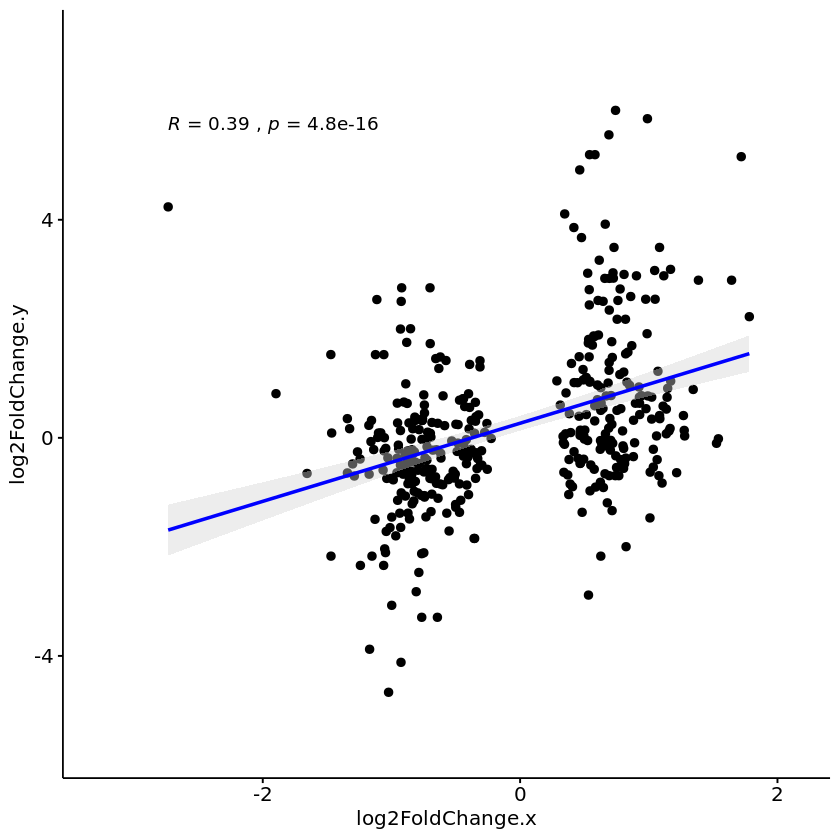

In [11]:
AR=merge(MP[,c(1,2,3)],D_yan[,c(1,2,3)],by='X',all=FALSE)
dim(AR)
D_min=min(AR$log2FoldChange.x)
D_max=max(AR$log2FoldChange.x)
R_min=min(AR$log2FoldChange.y)
R_max=max(AR$log2FoldChange.y)


p2 <- ggscatter(AR, x = "log2FoldChange.x", y = "log2FoldChange.y",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

#ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max),xlab="log2fc(ATAC)", ylab="log2fc(RNA)")
ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max))

[1] 447   5

`geom_smooth()` using formula 'y ~ x'
Warning message:
“`as_data_frame()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”Warning message:
“The `printer` argument is deprecated as of rlang 0.3.0.
This warning is displayed once per session.”

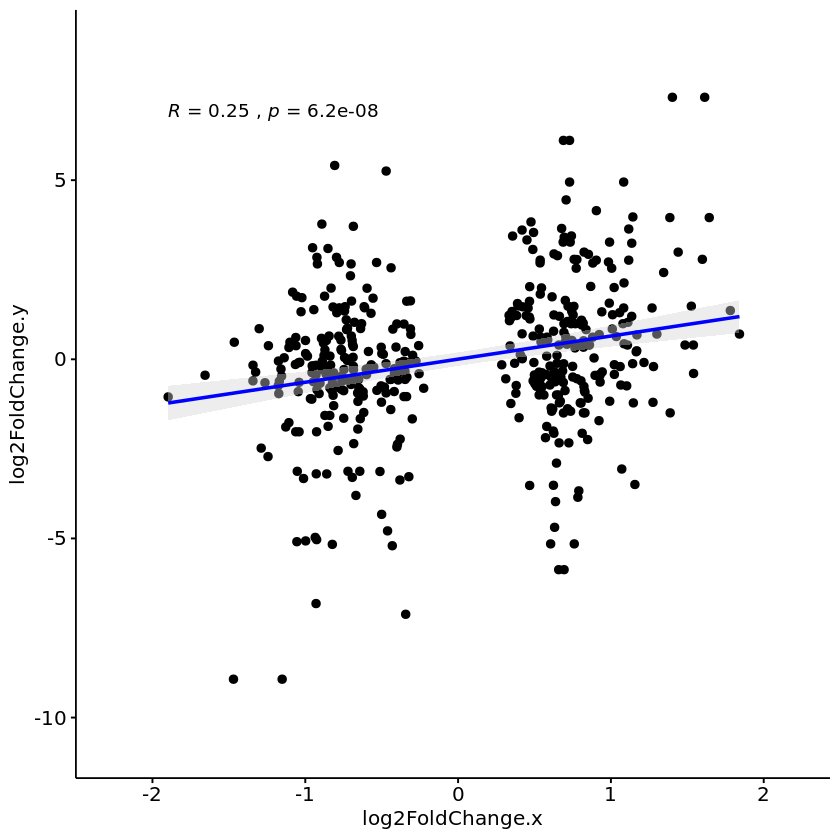

In [10]:
AR=merge(MP[,c(1,2,3)],D_xin[,c(1,2,3)],by='X',all=FALSE)
dim(AR)
D_min=min(AR$log2FoldChange.x)
D_max=max(AR$log2FoldChange.x)
R_min=min(AR$log2FoldChange.y)
R_max=max(AR$log2FoldChange.y)


p2 <- ggscatter(AR, x = "log2FoldChange.x", y = "log2FoldChange.y",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

#ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max),xlab="log2fc(ATAC)", ylab="log2fc(RNA)")
ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max))

[1] 486   5

`geom_smooth()` using formula 'y ~ x'


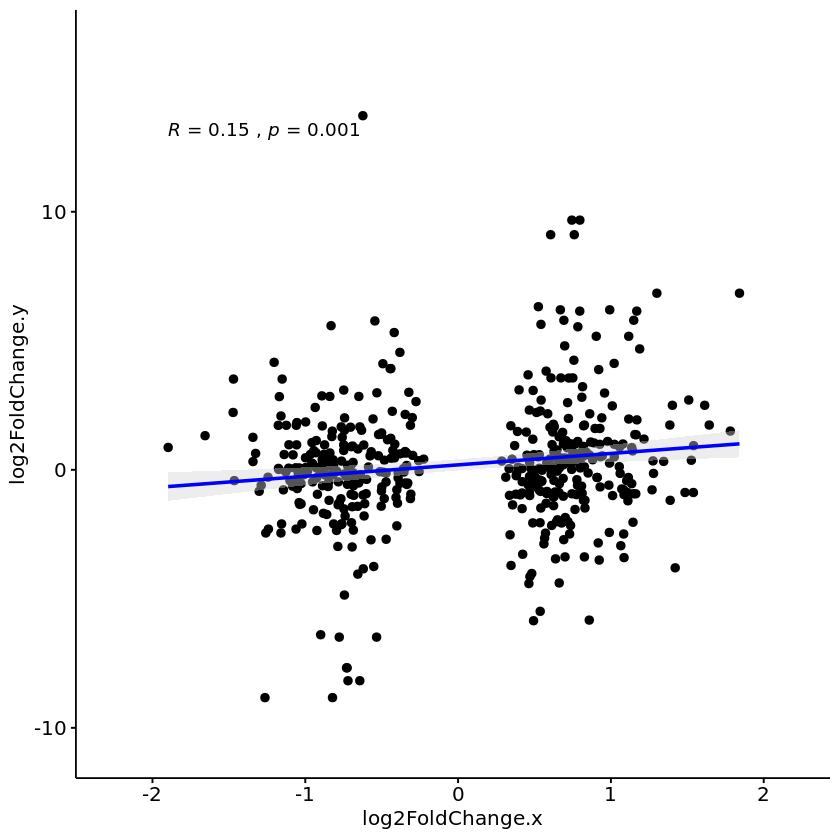

In [12]:
## promoter accessibility vs gene expression (Seg et al.)

AR=merge(MP[,c(1,2,3)],D_Seg[,c(1,2,3)],by='X',all=FALSE)
dim(AR)
D_min=min(AR$log2FoldChange.x)
D_max=max(AR$log2FoldChange.x)
R_min=min(AR$log2FoldChange.y)
R_max=max(AR$log2FoldChange.y)


p2 <- ggscatter(AR, x = "log2FoldChange.x", y = "log2FoldChange.y",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

#ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max),xlab="log2fc(ATAC)", ylab="log2fc(RNA)")
ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max))

[1] 1779    5

`geom_smooth()` using formula 'y ~ x'


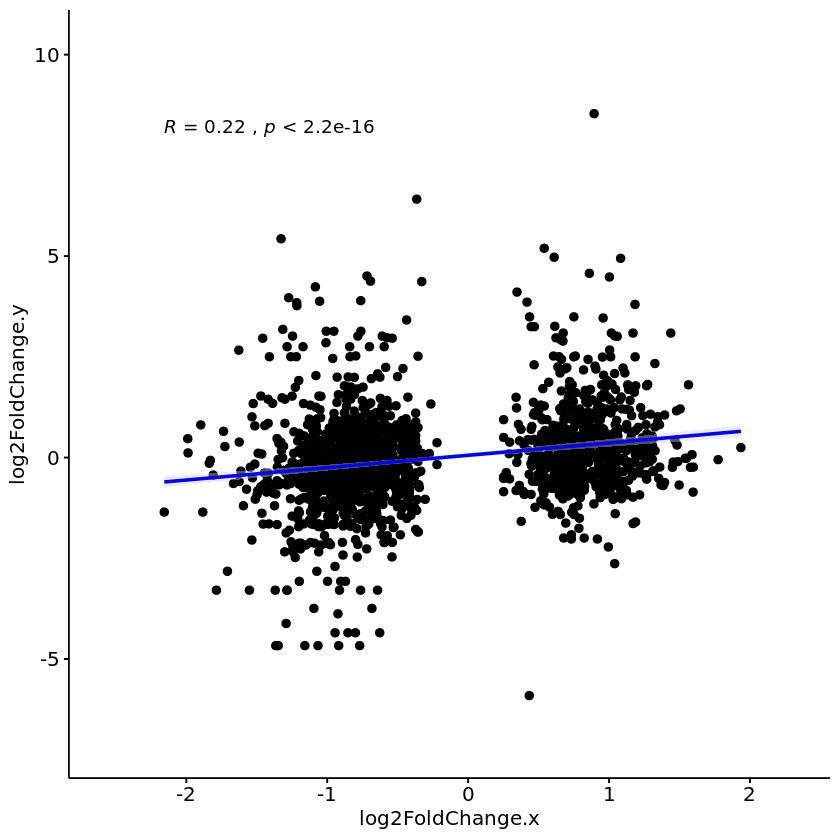

In [14]:
AR=merge(MA[,c(1,2,3)],D_yan[,c(1,2,3)],by='X',all=FALSE)
dim(AR)
D_min=min(AR$log2FoldChange.x)
D_max=max(AR$log2FoldChange.x)
R_min=min(AR$log2FoldChange.y)
R_max=max(AR$log2FoldChange.y)


p2 <- ggscatter(AR, x = "log2FoldChange.x", y = "log2FoldChange.y",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

#ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max),xlab="log2fc(ATAC)", ylab="log2fc(RNA)")
ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max))

[1] 1863    5

`geom_smooth()` using formula 'y ~ x'


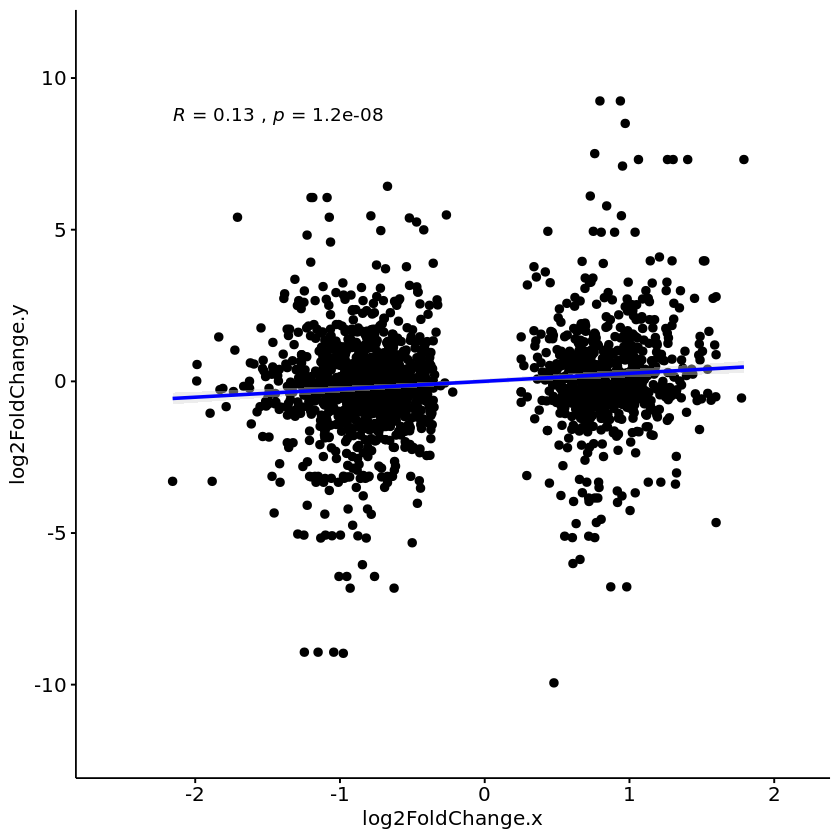

In [13]:
## promoter accessibility vs gene expression (Xin et al.)

AR=merge(MA[,c(1,2,3)],D_xin[,c(1,2,3)],by='X',all=FALSE)
dim(AR)
D_min=min(AR$log2FoldChange.x)
D_max=max(AR$log2FoldChange.x)
R_min=min(AR$log2FoldChange.y)
R_max=max(AR$log2FoldChange.y)


p2 <- ggscatter(AR, x = "log2FoldChange.x", y = "log2FoldChange.y",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

#ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max),xlab="log2fc(ATAC)", ylab="log2fc(RNA)")
ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max))

[1] 1947    5

`geom_smooth()` using formula 'y ~ x'


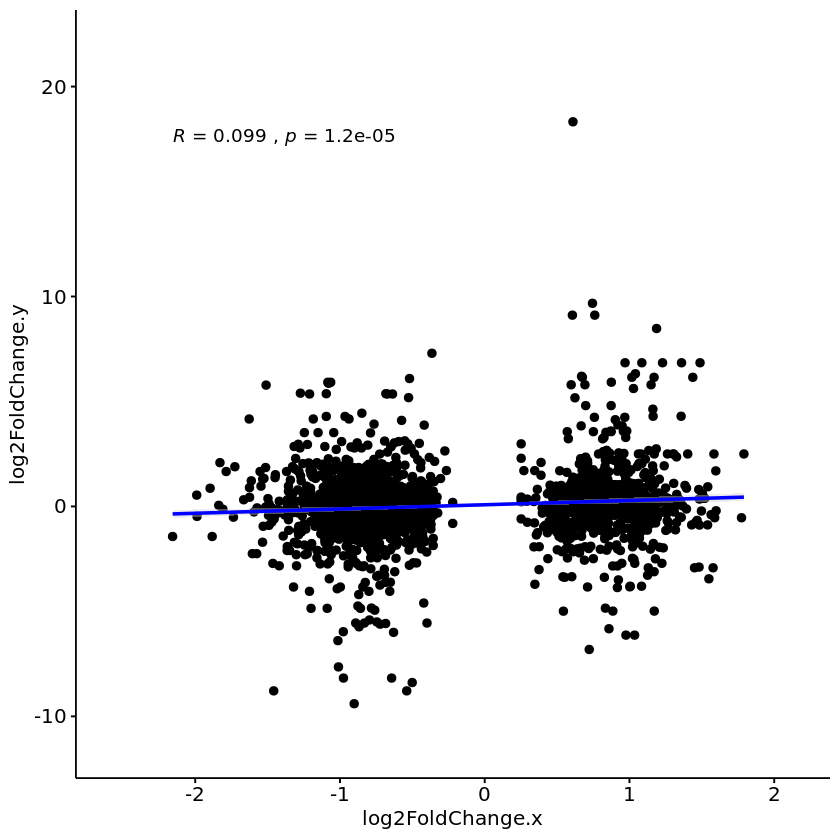

In [15]:
AR=merge(MA[,c(1,2,3)],D_Seg[,c(1,2,3)],by='X',all=FALSE)
dim(AR)
D_min=min(AR$log2FoldChange.x)
D_max=max(AR$log2FoldChange.x)
R_min=min(AR$log2FoldChange.y)
R_max=max(AR$log2FoldChange.y)


p2 <- ggscatter(AR, x = "log2FoldChange.x", y = "log2FoldChange.y",
               add = "reg.line",  # Add regressin line)
     add.params = list(color = "blue", fill = "lightgray"),
               conf.int = TRUE,
               cor.coef = TRUE)

#ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max),xlab="log2fc(ATAC)", ylab="log2fc(RNA)")
ggpar(p2,xlim = c(1.2*D_min,1.2*D_max),ylim = c(1.2*R_min,1.2*R_max))

# heatmap

In [43]:
## beta cell as an example
rm(list = ls())
c_type='beta'

## beta cell open cCREs
name_c1=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_peak_macs2_q0.05.bed')
C1=read.table(name_c1,sep='\t')
peak_c1=unique(as.character(C1$V4))

## beta cell bulk count matrix
name_c3=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_500_all_b.csv')
C3=read.csv(name_c3)
peak_all_c3=as.character(C3$index)
C3_matrix=as.matrix(C3[,-1])
rownames(C3_matrix)=peak_all_c3
keep=(peak_all_c3 %in% peak_c1)
C3_final=C3_matrix[keep,]

## count normalization (CPM)
A_norm = C3_final - C3_final
r_sum=colSums(C3_final)
for (i in 1:dim(A_norm)[2]){
  A_norm[,i]=((1000000/r_sum[i])*C3_final[,i])
}
A_raw=C3_final

C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
C=C[order(C$donor),]
all(C$donor==colnames(A_norm))

[1] TRUE

In [28]:
####### PCA plot
rm(list = ls())
c_type='beta'
name_c1=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_peak_macs2_q0.05.bed')
C1=read.table(name_c1,sep='\t')
peak_c1=unique(as.character(C1$V4))

##c3: bulk-count
name_c3=paste0('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/',c_type,'_500_all_b.csv')
C3=read.csv(name_c3)
peak_all_c3=as.character(C3$index)
C3_matrix=as.matrix(C3[,-1])
rownames(C3_matrix)=peak_all_c3

keep=(peak_all_c3 %in% peak_c1)
C3_final=C3_matrix[keep,]

## count normalization, matrix format: samples*features
A_norm = C3_final - C3_final
r_sum=colSums(C3_final)

for (i in 1:dim(A_norm)[2]){
  A_norm[,i]=((1000000/r_sum[i])*C3_final[,i])
}

A_norm[1:3,1:3]
A_raw=C3_final

C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
C=C[order(C$donor),]
all(C$donor==colnames(A_norm))

,JYH792,JYH809,MM108
1:100009946-100010446,3.2896165,4.3664191,7.546834
1:100014513-100015013,3.4723729,2.6870272,3.913173
1:100017730-100018230,0.3655129,0.6717568,1.677074


[1] TRUE

In [29]:
## beta cell differential cCREs
A_TN=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_T2D_Non_biobank.csv') ##
A_TP=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_T2D_Pre_biobank.csv') ##
A_PN=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_Pre_Non_biobank.csv') ##
all(rownames(A_TN)==rownames(A_TP))

A1=A_PN
colnames(A1)=c('X','baseMean','log2FC_PN','lfcSE_PN','stat_PN','pvalue_PN','padj_PN')
A2=A_TP[,c(3:7)]
colnames(A2)=c('log2FC_TP','lfcSE_TP','stat_TP','pvalue_TP','padj_TP')
A3=A_TN[,c(3:7)]
colnames(A3)=c('log2FC_TN','lfcSE_TN','stat_TN','pvalue_TN','padj_TN')
tt=cbind(A1,A2)
A=cbind(tt,A3)


A[is.na(A)]=10
peak_all=as.character(A$X)
peak_TNup_biobank=peak_all[A$stat_TN>0 & A$padj_TN<0.1]
peak_TNdown_biobank=peak_all[A$stat_TN<0 & A$padj_TN<0.1]
peak_PNup_biobank=peak_all[A$stat_PN>0 & A$padj_PN<0.1]
peak_PNdown_biobank=peak_all[A$stat_PN<0 & A$padj_PN<0.1]
peak_TPup_biobank=peak_all[A$stat_TP>0 & A$padj_TP<0.1]
peak_TPdown_biobank=peak_all[A$stat_TP<0 & A$padj_TP<0.1]


length(peak_PNup_biobank)
length(peak_PNdown_biobank)
length(peak_TPup_biobank)
length(peak_TPdown_biobank)
length(peak_TNup_biobank)
length(peak_TNdown_biobank)

peak_merge=c(peak_PNup_biobank,peak_PNdown_biobank,peak_TPup_biobank,peak_TPdown_biobank,peak_TNup_biobank,peak_TNdown_biobank)
length(peak_merge)


[1] TRUE

[1] 0

[1] 0

[1] 61

[1] 98

[1] 3097

[1] 3614

[1] 6870

[1] TRUE

[1] TRUE

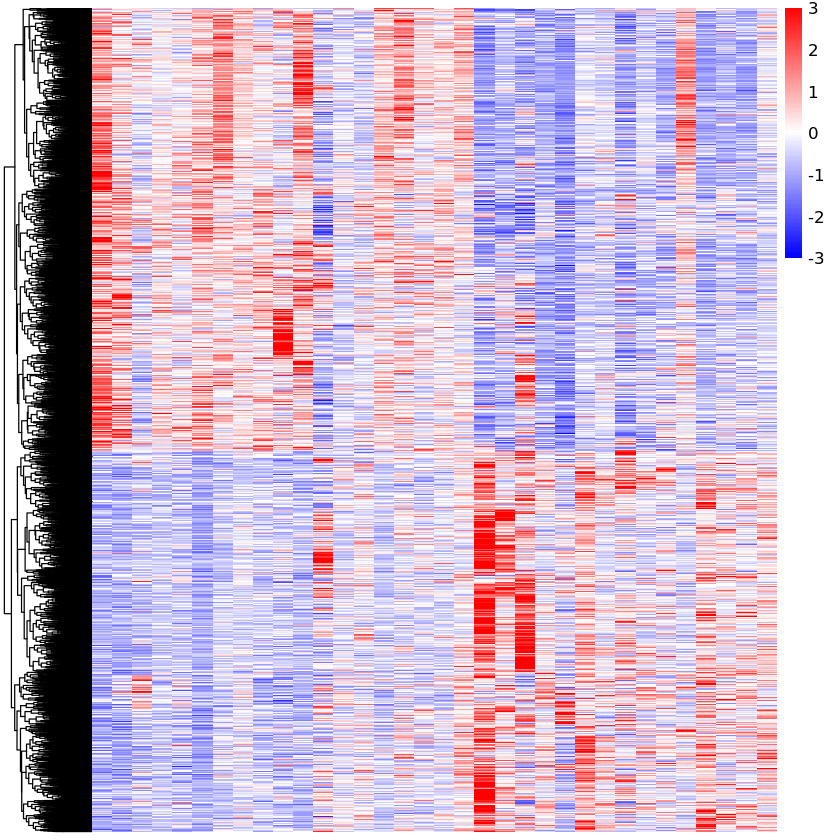

In [30]:
## Heatmap
A_temp=A_norm[(rownames(A_norm) %in% peak_merge),]
C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
C=C[order(C$donor),]
all(as.character(C$donor)==colnames(A_temp))

C1=C[order(C$Sample.Description.Name),]
A_temp1=A_temp[,order(C$Sample.Description.Name)]
all(as.character(C1$donor)==colnames(A_temp1))

bk = unique(c(seq(-3,3, length=100)))
pheatmap(A_temp1,scale='row',breaks=bk,color = colorRampPalette(colors = c("blue",'white',"red"))(100),show_rownames = F,show_colnames = F,cluster_cols=FALSE,)



## TF motif

In [14]:
## ChromVAR TF enrichment results
V=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/all_500_variability_2020.csv')
V1=as.matrix(V[,-c(1)])
rownames(V1)=as.character(V$X)
TF_temp=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_TFbydonor_2020.csv')
TF_M=as.matrix(TF_temp[,-1])
rownames(TF_M)=as.character(TF_temp$X)
rownames(TF_M)=as.character(V$name)

## metadata of donors
C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
C=C[order(C$donor),]
all(as.character(C$donor)==colnames(TF_M))

disease <- as.character(C$Sample.Description.Name)
donor_ID=as.character(C$donor)
TF_non=TF_M[,donor_ID %in% donor_ID[disease=='Non']]
TF_pre=TF_M[,donor_ID %in% donor_ID[disease=='Pre']]
TF_t2d=TF_M[,donor_ID %in% donor_ID[disease=='T2D']]
TF_all=cbind(TF_non,TF_pre,TF_t2d)


[1] TRUE

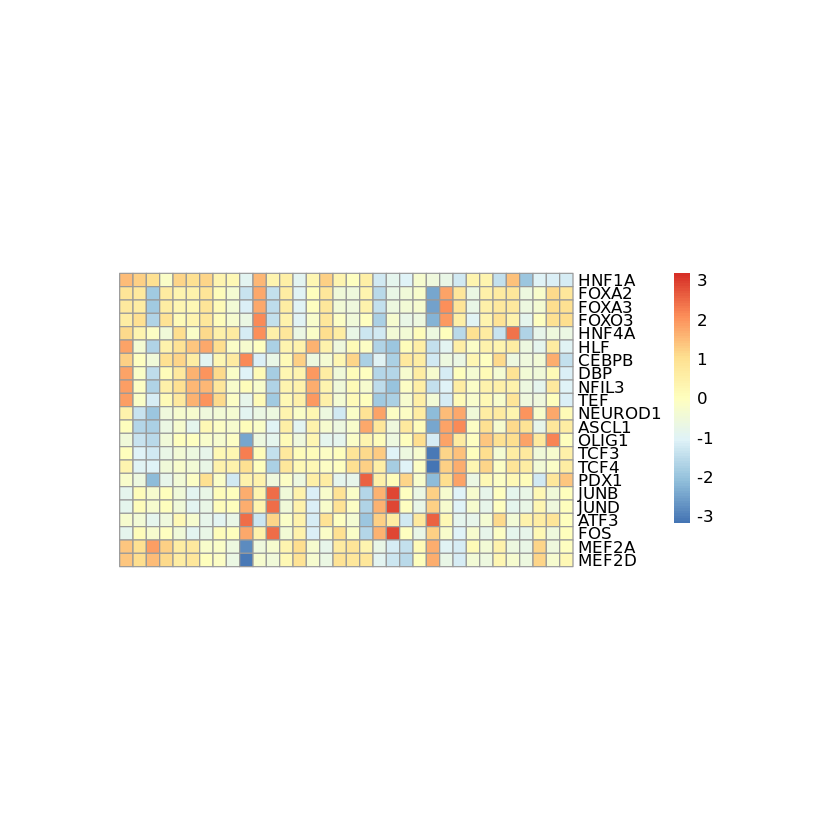

In [16]:
## enriched TF motifs from homer
TF_final=c('HNF1A','FOXA2','FOXA3','FOXO1','FOXO3','HNF4A','HLF','CEBPB','DBP','NFIL3','TEF','NEUROD1','ASCL1','OLIG1','TCF3','TCF4','PDX1','JUNB','JUND','ATF3','FOS','MEF2A','MEF2D')
TF_temp1=TF_all[(rownames(TF_all) %in% TF_final),]
TF_temp2=TF_temp1[c(4,14,13,3,16,15,8,2,20,9,10,11,7,21,22,5,17,18,12,1,19,6),]
pheatmap(TF_temp2,scale="row",show_colnames=FALSE,cluster_rows = FALSE,cluster_cols = FALSE, fontsize_col=6.8,cellwidth=8,cellheight=8)


In [22]:
TF_data=as.data.frame(t(TF_temp2))
TF_data=TF_data[order(rownames(TF_data)),]

C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
keep=(C$donor %in% rownames(TF_data))
C=C[keep,]
C=C[order(C$donor),]
all(C$donor==rownames(TF_data))

### add clinical infromation to each donor
TF_data$Disease=C$Sample.Description.Name
TF_data$method=C$Freezing.storage.method
TF_data$center=C$Center
TF_data$islet.index=C$islet.index
TF_data$age=C$Age
TF_data$gender=C$Gender
TF_data$BMI=C$BMI
TF_data$HbA1c=C$HbA1c
TF_data$Purity=C$Purity
TF_data

[1] TRUE

,HNF1A,FOXA2,FOXA3,FOXO3,HNF4A,HLF,CEBPB,DBP,NFIL3,TEF,⋯,MEF2D,Disease,method,center,islet.index,age,gender,BMI,HbA1c,Purity
JYH792,-0.2035146,0.106082133,0.07593138,0.049516372,-0.6585877,0.971279647,0.266898280,0.988299530,0.92657045,0.95360767,⋯,0.67154796,Non,snap frozen,CH,1.30,37,M,29.50,5.5,0.75
JYH809,-1.9247269,-1.000646243,-0.91708261,-0.652259050,-1.3729121,-0.308501427,-0.366296151,-0.233017052,-0.20114411,-0.31207101,⋯,-0.12267687,T2D,snap frozen,CH,1.40,57,M,23.30,7.3,0.73
MM108,-0.9247184,-0.963273619,-0.92188249,-0.569572217,-0.8571791,-0.322790282,-0.285192932,-0.281382208,-0.26103953,-0.31227107,⋯,0.04143604,Pre,Dry ice frozen,CH,1.30,34,F,31.50,5.7,0.80
MM109,-1.7076731,-0.618856240,-0.53178716,-0.222868345,-1.1257003,-0.404203120,-0.576267372,-0.230609786,-0.35879977,-0.28016649,⋯,-0.25050394,T2D,snap frozen,SC,1.34,54,M,23.60,5.8,0.83
MM110,-0.3862248,0.045455427,0.03089682,0.157077094,-0.8952054,0.187107611,-0.091470902,0.298208521,0.27971400,0.25974670,⋯,0.55258616,Non,snap frozen,SC,1.32,20,M,35.80,4.6,0.95
MM12,-1.8011632,-0.509334070,-0.44379093,-0.357608591,-1.1273568,0.331534059,0.130680956,0.257649065,0.26824632,0.21702053,⋯,-0.33698543,T2D,snap frozen,CH,1.01,52,M,29.90,8.3,0.75
MM120,-1.3465412,-0.399395306,-0.39278315,-0.317370990,-0.9670845,0.497853959,0.096371816,0.572403268,0.47466778,0.49824984,⋯,0.20682394,T2D,Dry ice frozen,CH,1.61,36,F,44.30,6.9,0.80
MM121,-1.5093061,-1.418421949,-1.40274914,-0.802518366,-1.1896282,-0.220407511,-0.433161760,0.260852797,-0.16193903,0.17685650,⋯,0.77539507,T2D,snap frozen,Penn,1.27,54,M,33.70,8.0,0.90
MM122,-1.6223124,0.548315961,0.68156250,0.446259037,-0.9913409,-0.031037034,-0.256920794,-0.057971933,-0.03458681,-0.07460615,⋯,-0.05528494,T2D,snap frozen,SL,0.84,66,F,29.10,7.2,0.85
MM123,-0.5212914,-1.157989547,-1.11112001,-0.632396791,-1.0371497,-0.306268194,-0.205584595,-0.180008214,-0.26157833,-0.07226699,⋯,0.70545959,Non,snap frozen,Penn,1.70,24,M,23.90,5.0,0.95


In [25]:
###########TF plot
rm(list = ls())
V=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/all_500_variability_2020.csv')
V1=as.matrix(V[,-c(1)])
rownames(V1)=as.character(V$X)
TF_temp=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_TFbydonor_2020.csv')
TF_M=as.matrix(TF_temp[,-1])
rownames(TF_M)=as.character(TF_temp$X)
rownames(TF_M)=as.character(V$name)

C=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/final_meta_2.csv')
C=C[order(C$donor),]
all(C$donor==colnames(TF_M))


[1] TRUE

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”Coordinate system already present. Adding new coordinate system, which will replace the existing one.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


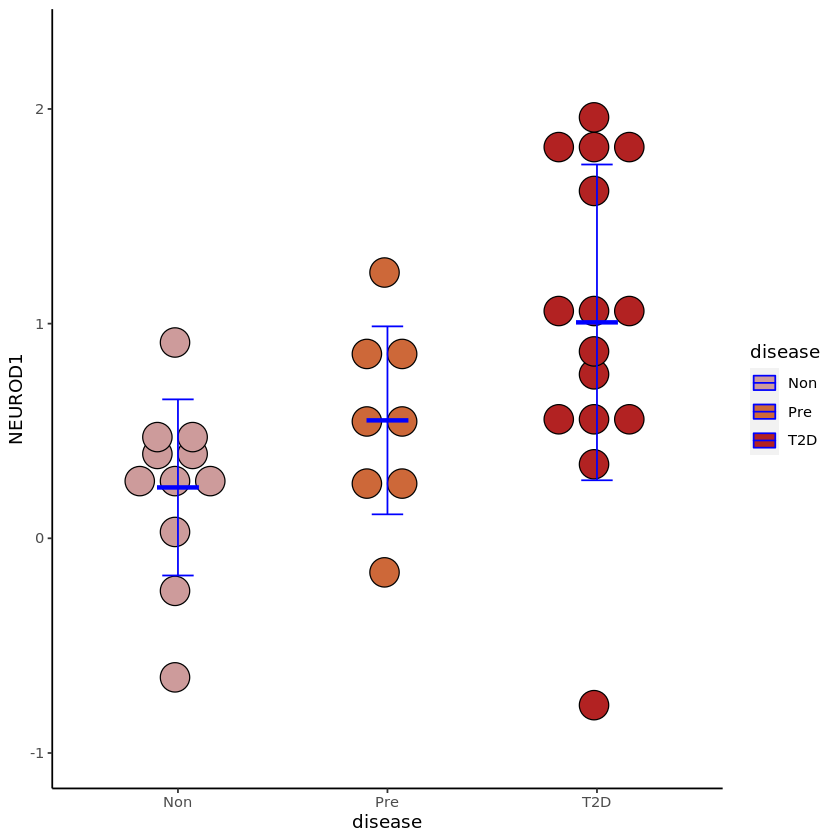

In [26]:
A_temp=TF_M[rownames(TF_M) %in% ('NEUROD1'),]
D=as.data.frame(t(TF_M[1:2,]))
D$disease=C$Sample.Description.Name
D$NEUROD1=TF_M[rownames(TF_M) %in% ('NEUROD1'),]

library(ggplot2) 
p <- ggplot(D, aes(x=disease, y=NEUROD1, fill=disease)) + geom_dotplot(binaxis='y',stackdir='center',stackratio=1.2,dotsize=1.5)
p1 <- p + stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="blue", width=0.15) + stat_summary(fun.y=mean, geom="crossbar",size=0.5,width=0.2,color="blue") + scale_fill_manual(values=c("#CD9B9B", "#CD6839", "#B22222"))

p1 + ggplot2::coord_cartesian(xlim=c(-3,3)) + ggplot2::coord_cartesian(ylim=c(-1,2.3)) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))

D_1=D[order(D$disease),]


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”Coordinate system already present. Adding new coordinate system, which will replace the existing one.
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


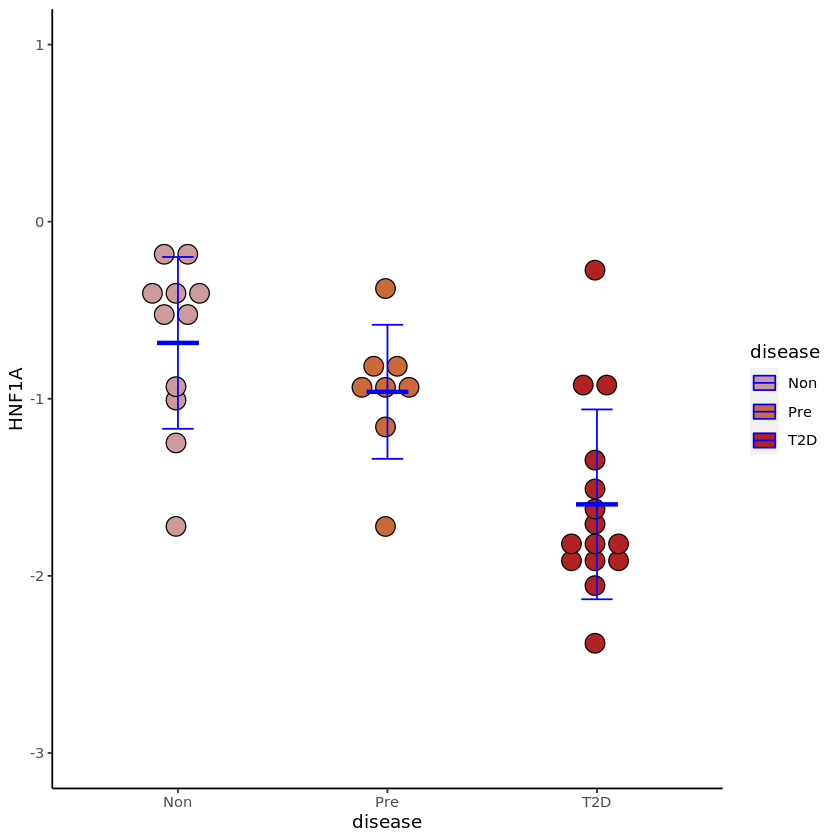

In [27]:
A_temp=TF_M[rownames(TF_M) %in% ('HNF1A'),]
D=as.data.frame(t(TF_M[1:2,]))
D$disease=C$Sample.Description.Name
D$HNF1A=TF_M[rownames(TF_M) %in% ('HNF1A'),]

library(ggplot2) 
p <- ggplot(D, aes(x=disease, y=HNF1A, fill=disease)) + geom_dotplot(binaxis='y',stackdir='center',stackratio=1.2,dotsize=1.5)
p1 <- p + stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="errorbar", color="blue", width=0.15) + stat_summary(fun.y=mean, geom="crossbar",size=0.5,width=0.2,color="blue") + scale_fill_manual(values=c("#CD9B9B", "#CD6839", "#B22222"))

p1 + ggplot2::coord_cartesian(xlim=c(-3,3)) + ggplot2::coord_cartesian(ylim=c(-3,1)) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))

D_1=D[order(D$disease),]


# TF trajectory

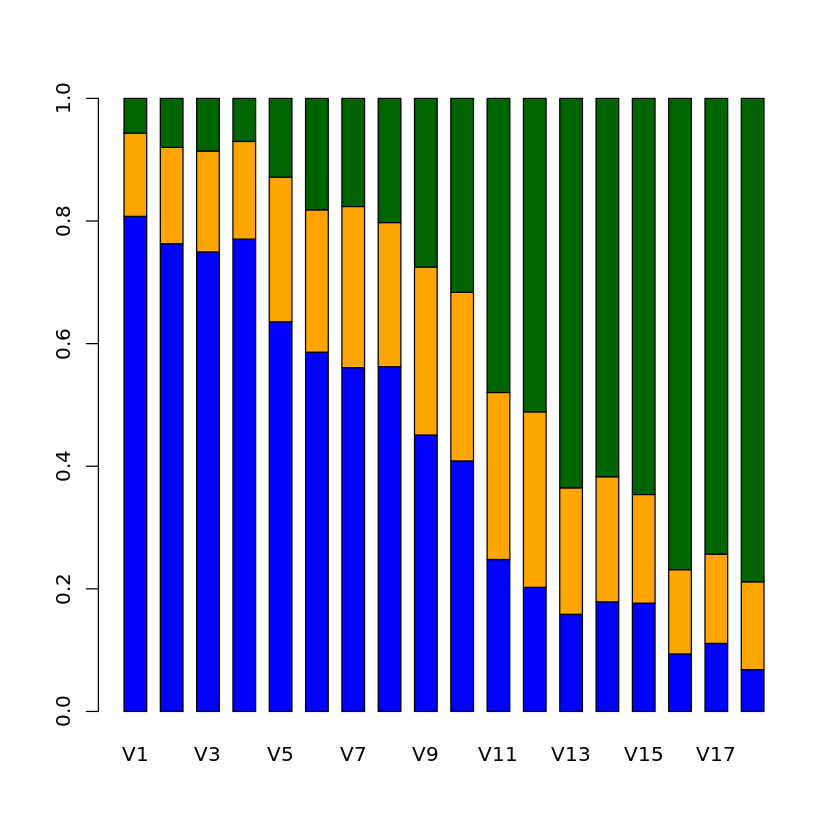

In [37]:
#### TF trajectory
A=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/trajectory_composition.csv')
A1=as.matrix(A[,-1])
rownames(A1)=as.character(A$X)
C1=A1

barplot(C1, space=0.6,col=c("blue","orange","darkgreen","red","purple","yellow","black"))


[1] 22 18

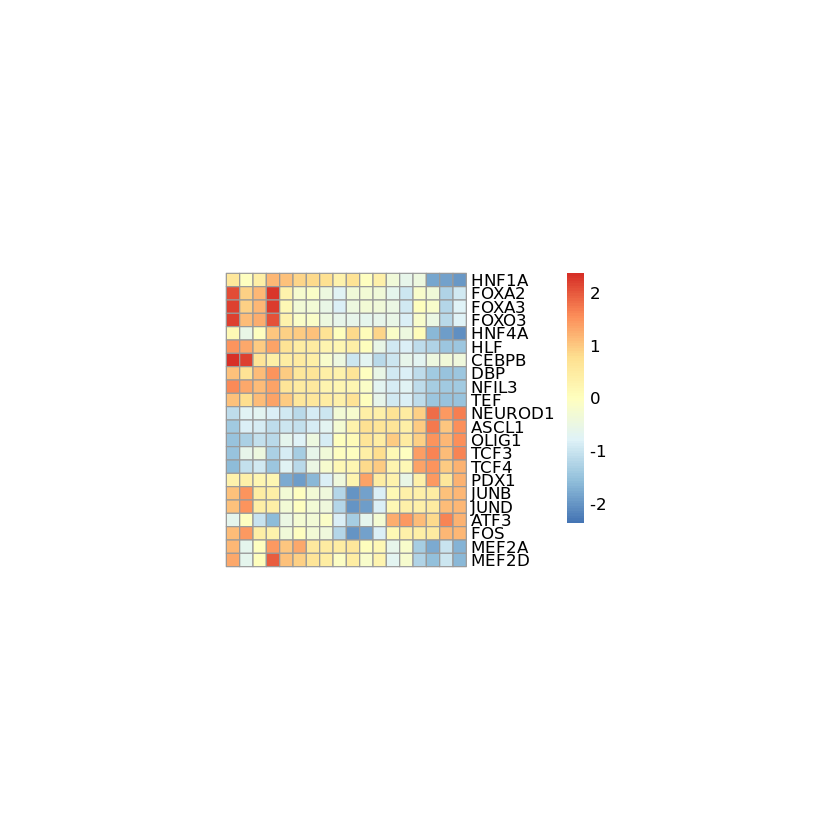

In [39]:
######### TF trajectory
A=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/TF_trajectory.csv')
A1=as.matrix(A[,-1])
rownames(A1)=as.character(A$X)

TF_final=c('HNF1A','FOXA2','FOXA3','FOXO1','FOXO3','HNF4A','HLF','CEBPB','DBP','NFIL3','TEF','NEUROD1','ASCL1','OLIG1','TCF3','TCF4','PDX1','JUNB','JUND','ATF3','FOS','MEF2A','MEF2D')
TF_temp1=A1[(rownames(A1) %in% TF_final),]
dim(TF_temp1)

TF_temp2=TF_temp1[c(4,14,13,3,16,15,8,2,20,9,10,11,7,21,22,5,17,18,12,1,19,6),]
pheatmap(TF_temp2,scale="row",show_colnames=FALSE,cluster_rows = FALSE,cluster_cols = FALSE, fontsize_col=6.8,cellwidth=8,cellheight=8)


# Expression level of TFs (public single cell RNA-seq data)

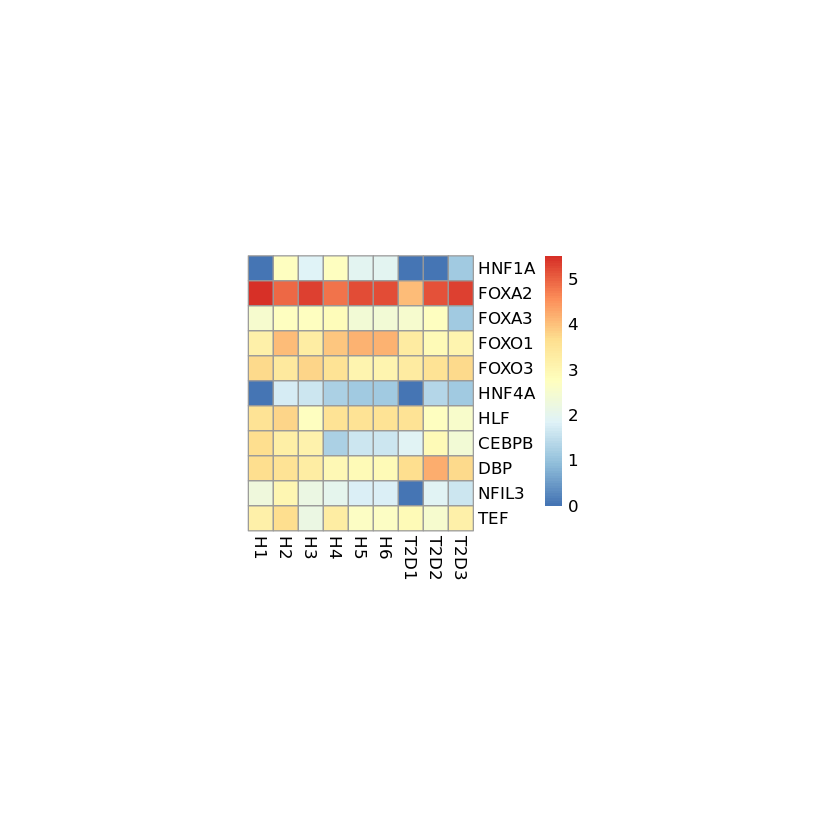

In [16]:
############ TF expression level
#Data: Fang, Z., et al. Single-Cell Heterogeneity Analysis and CRISPR Screen Identify Key beta-Cell-Specific Disease Genes. Cell Rep 26, 3132-3144 e3137 (2019).
A=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_bulk_Fang.csv')
A1=as.matrix(A[,-1])
rownames(A1)=toupper(as.character(A$index))
A_norm=A1-A1
k=dim(A1)[2]
for(i in 1:k){
  A_norm[,i]=(A1[,i]/sum(A1[,i]))*1000000  
}

TF_down=c('HNF1A','HNF1B','HNF4A','HLF','NFIL3','TEF','DBP','CEBPA','CEBPB','FOXA1','FOXA2','FOXA3','FOXB1','FOXB2','FOXC1','FOXC2','FOXD1','FOXD2','FOXD3','FOXD4','FOXO1','FOXO3','FOXO4','FOXO6','FOXM1')
TF_up=c('NEUROD1','NEUROD2','TCF2','TCF3','TCF4','ATOH1','ATOH7','OLIG1','OLIG2','OLIG3','ASCL1','PDX1','FOSL','JUNB','JUND','ATF3','FOS','MEF2A','MEF2B','MEF2C','MEF2D')

A_down=A_norm[rownames(A_norm) %in% TF_down,]
TF_d=c('HNF1A','HNF4A','HLF','NFIL3','TEF','DBP','CEBPB','FOXA2','FOXO1','FOXO3','FOXA3')
A_down=A_down[rownames(A_down) %in% TF_d,]
A_down1=A_down[c(8,3:6,9,7,1:2,10:11),]

A_down2=log(A_down1+1)
pheatmap(A_down2,cluster_cols=FALSE,cluster_rows=FALSE,cellheight = 15,cellwidth  = 15)


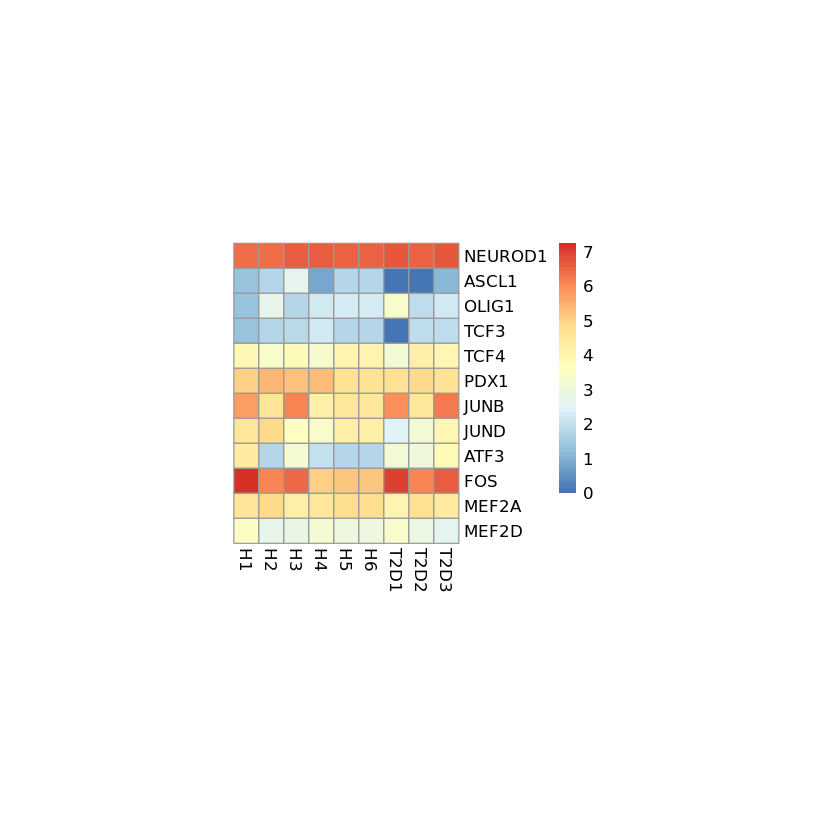

In [17]:
A_up=A_norm[rownames(A_norm) %in% TF_up,]
keep=(rowMeans(A_up)>3)
A_up=A_up[keep,]

TF_a=c('ASCL1','ATF3','FOS','PDX1','JUNB','JUND','MEF2A','MEF2D','NEUROD1','TCF3','TCF4','OLIG1')
A_up=A_up[rownames(A_up) %in% TF_a,]
A_up1=A_up[c(8,1,9,11:12,10,4:5,2,3,6:7),]

A_up2=log(A_up1+1)
pheatmap(A_up2,cluster_cols=FALSE,cluster_rows=FALSE,cellheight = 15,cellwidth  = 15)


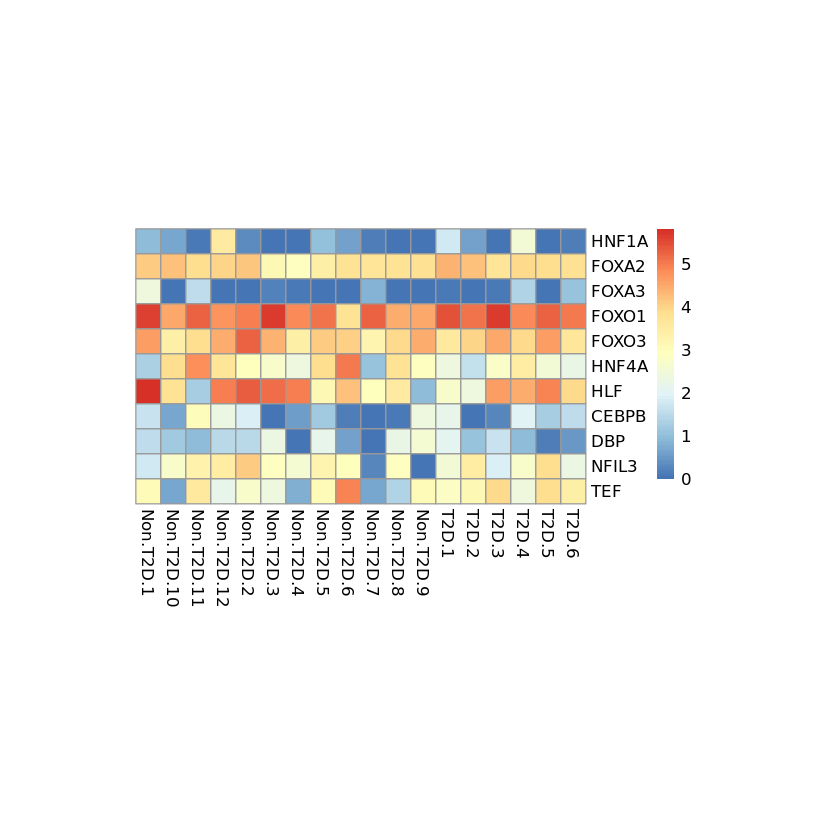

In [19]:
################## TF expression level
#Data: Xin, Y., et al. RNA Sequencing of Single Human Islet Cells Reveals Type 2 Diabetes Genes. Cell Metab 24, 608-615 (2016).
A=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_bulk_xin.csv')
A1=as.matrix(A[,-1])
rownames(A1)=toupper(as.character(A$X))
A_norm=A1-A1
k=dim(A1)[2]
for(i in 1:k){
  A_norm[,i]=(A1[,i]/sum(A1[,i]))*1000000  
}

TF_down=c('HNF1A','HNF1B','HNF4A','HLF','NFIL3','TEF','DBP','CEBPA','CEBPB','FOXA1','FOXA2','FOXA3','FOXB1','FOXB2','FOXC1','FOXC2','FOXD1','FOXD2','FOXD3','FOXD4','FOXO1','FOXO3','FOXO4','FOXO6','FOXM1')
TF_up=c('NEUROD1','NEUROD2','TCF2','TCF3','TCF4','ATOH1','ATOH7','OLIG1','OLIG2','OLIG3','ASCL1','PDX1','FOSL','JUNB','JUND','ATF3','FOS','MEF2A','MEF2B','MEF2C','MEF2D')

A_down=A_norm[rownames(A_norm) %in% TF_down,]
TF_d=c('HNF1A','HNF4A','HLF','NFIL3','TEF','DBP','CEBPB','FOXA2','FOXO1','FOXO3','FOXA3')
A_down=A_down[rownames(A_down) %in% TF_d,]
A_down1=A_down[c(10,6,7,3,4,8,5,1,2,9,11),] 

A_down2=log(A_down1+1)
pheatmap(A_down2,cluster_cols=FALSE,cluster_rows=FALSE,cellheight = 15,cellwidth  = 15)


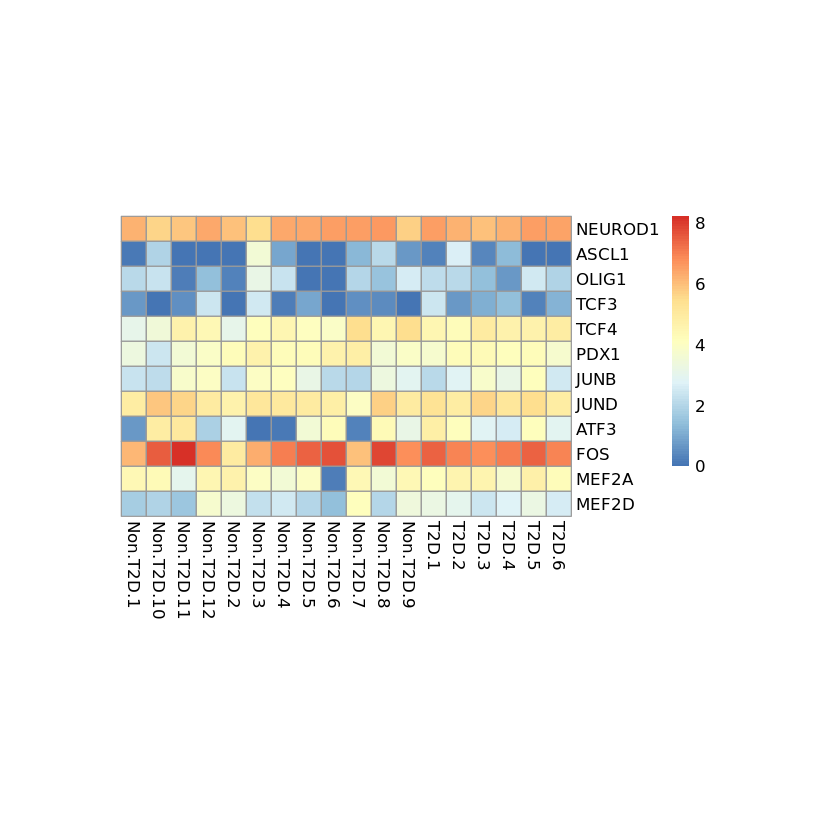

In [20]:
A_up=A_norm[rownames(A_norm) %in% TF_up,]
TF_a=c('ASCL1','ATF3','FOS','PDX1','JUNB','JUND','MEF2A','MEF2D','NEUROD1','TCF3','TCF4','OLIG1')
A_up=A_up[rownames(A_up) %in% TF_a,]
A_up1=A_up[c(9,1,12,11,10,4,5,6,2,3,7,8),]

A_up2=log(A_up1+1)
pheatmap(A_up2,cluster_cols=FALSE,cluster_rows=FALSE,cellheight = 15,cellwidth  = 15)



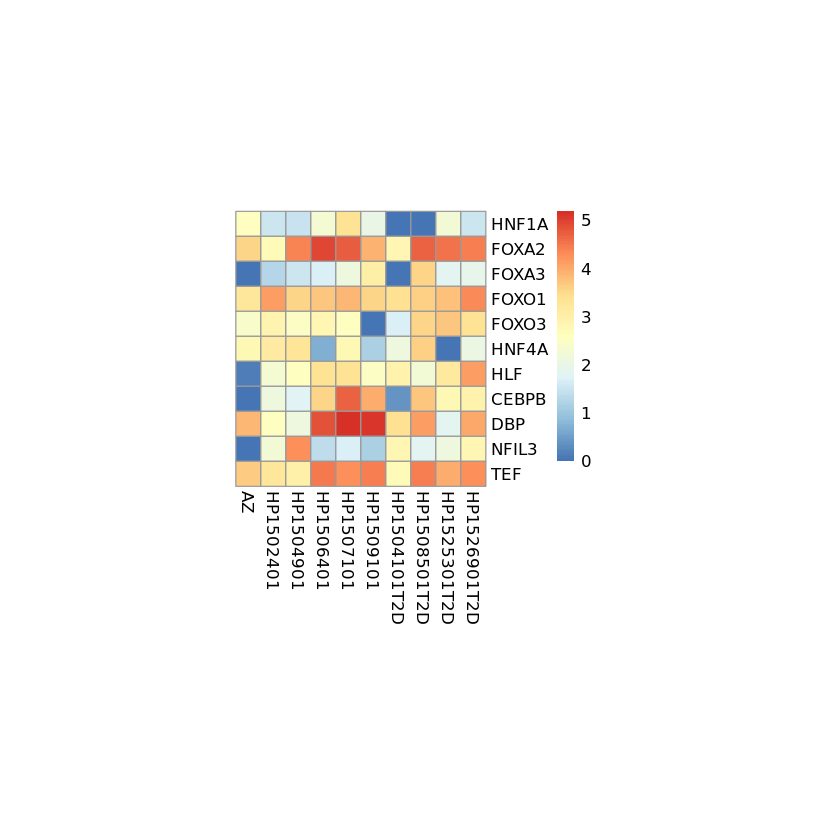

In [21]:
############ TF expression level
#Data: Segerstolpe, A., et al. Single-Cell Transcriptome Profiling of Human Pancreatic Islets in Health and Type 2 Diabetes. Cell Metab 24, 593-607 (2016).

A=read.csv('/oasis/tscc/scratch/gaw006/share/biobank_snATACseq/beta_bulk_seg.csv')
A1=as.matrix(A[,-1])
rownames(A1)=toupper(as.character(A$X))
A_norm=A1-A1
k=dim(A1)[2]
for(i in 1:k){
  A_norm[,i]=(A1[,i]/sum(A1[,i]))*1000000  
}

TF_down=c('HNF1A','HNF1B','HNF4A','HLF','NFIL3','TEF','DBP','CEBPA','CEBPB','FOXA1','FOXA2','FOXA3','FOXB1','FOXB2','FOXC1','FOXC2','FOXD1','FOXD2','FOXD3','FOXD4','FOXO1','FOXO3','FOXO4','FOXO6','FOXM1')
TF_up=c('NEUROD1','NEUROD2','TCF2','TCF3','TCF4','ATOH1','ATOH7','OLIG1','OLIG2','OLIG3','ASCL1','PDX1','FOSL','JUNB','JUND','ATF3','FOS','MEF2A','MEF2B','MEF2C','MEF2D')

A_down=A_norm[rownames(A_norm) %in% TF_down,]
TF_d=c('HNF1A','HNF4A','HLF','NFIL3','TEF','DBP','CEBPB','FOXA2','FOXO1','FOXO3','FOXA3')
A_down=A_down[rownames(A_down) %in% TF_d,]
A_down1=A_down[c(3,9,6,4,1,8,5,10,7,2,11),] 

A_down2=log(A_down1+1)
pheatmap(A_down2[,c(1,2,4:6,8,3,7,9,10)],cluster_cols=FALSE,cluster_rows=FALSE,cellheight = 15,cellwidth  = 15)



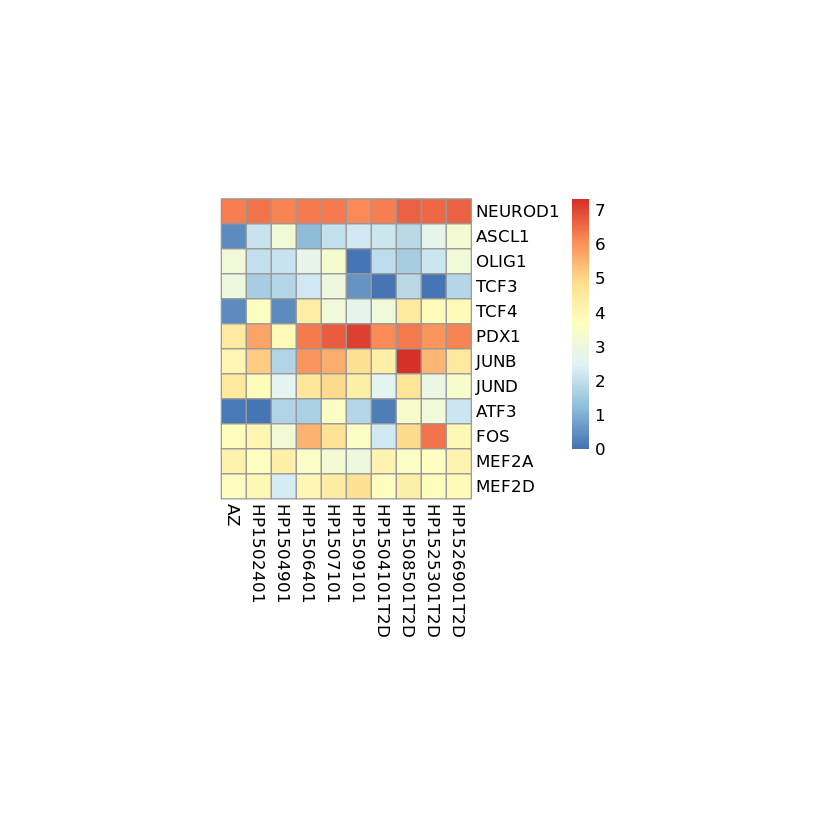

In [22]:
A_up=A_norm[rownames(A_norm) %in% TF_up,]
TF_a=c('ASCL1','ATF3','FOS','PDX1','JUNB','JUND','MEF2A','MEF2D','NEUROD1','TCF3','TCF4','OLIG1')
A_up=A_up[rownames(A_up) %in% TF_a,]
A_up1=A_up[c(3,4,12,9,8,5,10,11,2,6,7,1),]

A_up2=log(A_up1+1)
pheatmap(A_up2[,c(1,2,4:6,8,3,7,9,10)],cluster_cols=FALSE,cluster_rows=FALSE,cellheight = 15,cellwidth  = 15)
